# Fitting line profiles with lorentzian and Gausian

In [2]:
import sys
sys.path.append('D:/solar flares/data/2017-09-06')
import use_nessi3 as un
import data_analysis as da
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
import os
from importlib import reload
# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors
# from scipy.interpolate import interp1d


In [3]:
lines = ["Ha17", "CaK17", "CaII17"]
long_names = {"Ha17":r"H$\alpha$", "CaK17":r'Ca$IIK$', "CaII17":r'Ca$II 8542 \AA$'}


data0 = un.load_for_further_analysis(lines, full_path="D:/solar flares/data/2017-09-06/")
un2.disgard_cont_point("CaK17", data0)
data0.keys()

dict_keys(['FOV_Ha17', 'quiet_sun_Ha17', 'nessi_Ha17', 'TIME_Ha17', 'FOV_CaK17', 'quiet_sun_CaK17', 'nessi_CaK17', 'TIME_CaK17', 'FOV_CaII17', 'quiet_sun_CaII17', 'nessi_CaII17', 'TIME_CaII17'])

In [4]:
data0['quiet_sun_Ha17']

array([[6.56150000e+03, 6.56200000e+03, 6.56220000e+03, 6.56240000e+03,
        6.56270000e+03, 6.56285000e+03, 6.56300000e+03, 6.56315000e+03,
        6.56330000e+03, 6.56360000e+03, 6.56380000e+03, 6.56400000e+03,
        6.56450000e+03],
       [2.76978401e-08, 2.52960703e-08, 2.27472038e-08, 1.71177930e-08,
        9.99433646e-09, 9.32648929e-09, 9.15971860e-09, 9.58517635e-09,
        1.05578090e-08, 1.84215002e-08, 2.28937997e-08, 2.52214757e-08,
        2.71713987e-08],
       [5.22207581e-02, 3.78950462e-02, 4.08104956e-02, 8.45079795e-02,
        9.83282924e-02, 9.55938324e-02, 9.06255320e-02, 9.14372727e-02,
        8.36121216e-02, 4.07840125e-02, 3.61596309e-02, 3.84186432e-02,
        5.16747981e-02]])

In [5]:
wav, spec, std = data0['quiet_sun_Ha17']
wav, spec


(array([6561.49999988, 6562.        , 6562.19999999, 6562.39999998,
        6562.69999999, 6562.84999999, 6563.        , 6563.15000001,
        6563.30000001, 6563.60000002, 6563.80000001, 6564.        ,
        6564.50000012]),
 array([2.76978401e-08, 2.52960703e-08, 2.27472038e-08, 1.71177930e-08,
        9.99433646e-09, 9.32648929e-09, 9.15971860e-09, 9.58517635e-09,
        1.05578090e-08, 1.84215002e-08, 2.28937997e-08, 2.52214757e-08,
        2.71713987e-08]))

In [6]:
reload(un2)
wav, DFOV , time, line, std = un2.contrast_FOV_data('Ha17', data0, quiet_sun_subtraction=False, num=20)
wav, DFOV , time, line 

the correction factor is 0.8739210853601194


(array([6561.49999988, 6561.65789463, 6561.81578938, 6561.97368413,
        6562.13157888, 6562.28947363, 6562.44736838, 6562.60526313,
        6562.76315788, 6562.92105263, 6563.07894737, 6563.23684212,
        6563.39473687, 6563.55263162, 6563.71052637, 6563.86842112,
        6564.02631587, 6564.18421062, 6564.34210537, 6564.50000012]),
 array([[ 0.00630183,  0.0213002 ,  0.03922733, ...,  0.07885642,
          0.11168898,  0.01074868],
        [ 0.00699859,  0.02188792,  0.039706  , ...,  0.08526155,
          0.11919768,  0.01936097],
        [ 0.01515173,  0.03131892,  0.05041487, ...,  0.09338471,
          0.12660294,  0.02604833],
        ...,
        [-0.13477818, -0.12391512, -0.11012333, ..., -0.09317799,
         -0.05541949, -0.15143383],
        [-0.13444116, -0.12383371, -0.11029752, ..., -0.09220379,
         -0.05404427, -0.14965759],
        [-0.1359685 , -0.12453167, -0.11016609, ..., -0.09296143,
         -0.05416997, -0.14915136]]),
 array([ 3.75      ,  4.       

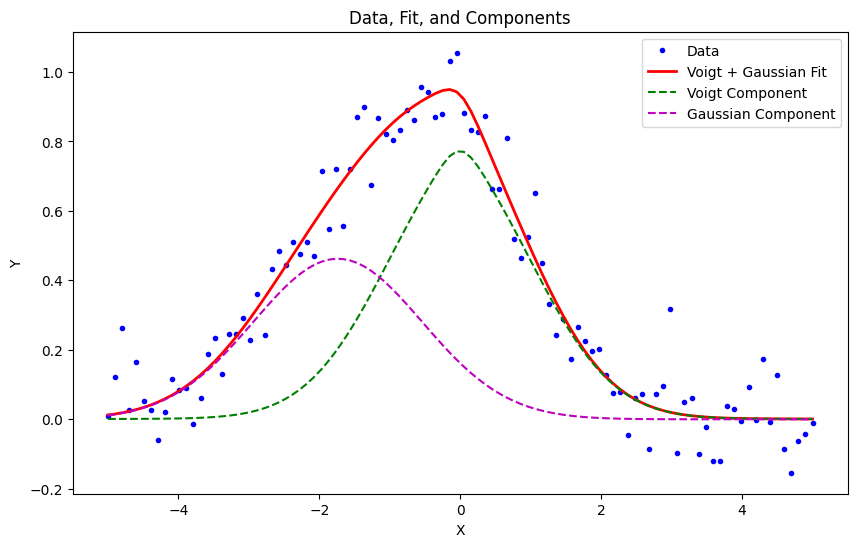

In [7]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian(x, amp_g, cen_g, sigma_g):
    """Gaussian function."""
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    """Lorentzian function."""
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, amp_v, cen_v, sigma_v, gamma_v, offset=0):
    """Voigt profile: approximation by combining Gaussian and Lorentzian."""
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset

def voigt_plus_gaussian(x, amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g):
    """Combination of a Voigt profile and an additional Gaussian."""
    return voigt(x, amp_v, cen_v, sigma_v, gamma_v) + gaussian(x, amp_g, cen_g, sigma_g)

def fit_voigt_and_gaussian(x_data, y_data, initial_guess):
    """Fit a Voigt and Gaussian profile to the data."""
    popt, pcov = curve_fit(voigt_plus_gaussian, x_data, y_data, p0=initial_guess)
    return popt, np.sqrt(np.diag(pcov))

def fit_voigt(x_data, y_data, initial_guess):
    """Fit a Voigt profile to the data."""
    popt, pcov = curve_fit(voigt, x_data, y_data, p0=initial_guess)
    return popt, np.sqrt(np.diag(pcov))

def plot_data_fit_and_components(x_data, y_data, initial_guess, popt=None):
    """Plot the data, fit, and components."""
    if popt is None:
        popt, _ = fit_voigt_and_gaussian(x_data, y_data, initial_guess)
    y_fit = voigt_plus_gaussian(x_data, *popt)
    y_voigt = voigt(x_data, popt[0], popt[1], popt[2], popt[3])
    y_gaussian = gaussian(x_data, popt[4], popt[5], popt[6])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'b.', label='Data')
    plt.plot(x_data, y_fit, 'r-', linewidth=2, label='Voigt + Gaussian Fit')
    plt.plot(x_data, y_voigt, 'g--', label='Voigt Component')
    plt.plot(x_data, y_gaussian, 'm--', label='Gaussian Component')
    plt.title('Data, Fit, and Components')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
def plot_data_fit_voigt(x_data, y_data, initial_guess, popt=None, neglect_points=[]):
    """Plot the data, fit, and components."""
    if popt is None:
        popt, _ = fit_voigt(x_data, y_data, initial_guess)
    y_voigt = voigt(x_data, popt[0], popt[1], popt[2], popt[3])        
    y_diff = y_data - y_voigt
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'y.', label='Data neglected')
    plt.plot(np.delete(x_data,neglect_points, axis=0), np.delete(y_data,neglect_points, axis=0), 'b.', label='Data for fit')
    plt.plot(x_data, y_voigt, 'g--', label='Voigt Component')
    plt.plot(x_data, y_diff, 'r--', label='residue')
    plt.title('Data, Fit, and Components')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Generate synthetic data
x = np.linspace(-5, 5, 100)
y = voigt_plus_gaussian(x, 1, 0, 1, 0.5, 0.5, -2, 1) + np.random.normal(0, 0.1, len(x))

# Initial guess: [amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g]
initial_guess = [1, 0, 1, 1, 0.5, 0, 1]

# Plot the data, the fit, and the individual components
plot_data_fit_and_components(x, y, initial_guess)

In [9]:
def contrast_fit_voight_gauss(wav, contrast, intitial_guess, plot_rate=1000):

    param_fit = [] 
    residuals = []
    
    for i in range( np.shape(contrast)[0]):
        param_fit.append(fit_voigt_and_gaussian(wav, contrast[i], initial_guess))
        print(param_fit[i])
        
        if i%plot_rate == plot_rate-1:
            plot_data_fit_and_components(wav, contrast[i], initial_guess)
            
        popt = param_fit[-1][0]
        y_data = contrast[i]
        y_voigt = voigt(wav, popt[0], popt[1], popt[2], popt[3])
        y_diff = y_data - y_voigt
        residuals.append(y_diff)
        
    return param_fit, residuals
        
        
def contrast_fit_voight(wav, contrast, initial_guess, plot_rate=1000, neglect_points=[]):

    param_fit = [] 
    y_fits = []
    residuals = []
    
    for i in range( np.shape(contrast)[0]):
        try:
            w = np.delete(wav, neglect_points, axis=0)
            C = np.delete( contrast[i], neglect_points, axis=0)
            F = fit_voigt(w, C, initial_guess.copy())
            param_fit.append(F)
            
            if i%plot_rate == plot_rate-1:
                print(f'{param_fit[-1] = }. Here comes the plot:')
                plot_data_fit_voigt(wav, contrast[i], initial_guess, popt=F[0], neglect_points=neglect_points)
                
        except RuntimeError:
            if len(param_fit) == 0:
                print(f"At frame {i} the voight fitting was not succesfull and initial guess ({initial_guess}) is used as params and as std of params. ")
                param_fit.append((initial_guess, initial_guess))
            else:
                print(f"At frame {i} the voight fitting was not succesfull and previous params are used. ")
                param_fit.append(param_fit[-1])              
        popt = param_fit[-1][0]
        y_data = contrast[i]
        y_voigt = voigt(wav, popt[0], popt[1], popt[2], popt[3])
        y_fits.append(y_voigt)
        y_diff = y_data - y_voigt
        residuals.append(y_diff)
    try:
        return param_fit, np.array(y_fits) , np.array(residuals)
    except ValueError as error:
        print('The lenght of those arrays does not work out')
        t = [np.shape(k) for k in param_fit]
        print("the shapes of the param_fits:", set(t), t)
        t = [np.shape(k) for k in y_fits]
        print("the shapes of the y_fits:", set(t), t )
        t = [np.shape(k) for k in residuals]
        print("the shapes of the residuals:", set(t) , t)
        raise error
        
def make_analysis(name, data, initial_guess, plot_rate=50, offset=0, neglect_points=[]):
    wav, DFOV , time, line, std = un2.contrast_FOV_data(name, data, quiet_sun_subtraction=False, num=20)
    # print(np.shape(wav), np.shape(DFOV), np.shape(time), np.shape(line))
    # Initial guess: [amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g]
    # print(np.shape(wav), np.shape(np.delete(wav, neglect_points, axis=0)), wav, np.delete(wav, neglect_points, axis=0))
    # print(np.shape(DFOV+offset), np.shape(np.delete(DFOV+offset, neglect_points, axis=1)), DFOV+offset, np.delete(DFOV+offset, neglect_points, axis=1))
    params, voight, res = contrast_fit_voight(wav, DFOV+offset, initial_guess, plot_rate, neglect_points)
    visualize_analysis(res, voight, wav, time, name)
    save_voight_fits(name, params, res)
    
def save_voight_fits(name, params, res):
    fname = f"fit_data/voight_data_{name}.npz"
    np.savez(fname, params, res)

def load_voigth_data(name):
    fname = f"D:/solar flares/data/voigth_fitting/fit_data/voight_data_{name}.npz"
    data =  np.load(fname) 
    params = data['arr_0']
    res = data["arr_1"]
    return params, res    

def cut_off_data(data, up_lim=None, down_lim=None):
    if up_lim is None and down_lim is None:
        up_lim = max(-np.percentile(data, 3), np.percentile(data, 97))
        down_lim = - up_lim
    elif up_lim is None:
        up_lim = np.percentile(data, 97)
    elif down_lim is None:
        down_lim = np.percentile(data, 3)
    # Apply cutoff using boolean indexing and conditional assignment
    cutoff_data = np.where(data > up_lim, up_lim, data)
    cutoff_data = np.where(data < down_lim, down_lim, cutoff_data)
    return cutoff_data

def visualize_analysis(res, voight, wav, time, name):
    fig, ax = plt.subplots()
    if "Fe" in name or "CaI" in name:
        vlim = max(-np.percentile(res, 3), np.percentile(res, 97))
        print(f"{vlim = }")
        c = ax.imshow(np.array(res), aspect="auto", cmap='RdBu_r', origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]),
                    vmax=vlim, vmin=-vlim)
        voight = cut_off_data(voight)
    else:
        c = ax.imshow(np.array(res), aspect="auto", cmap='RdBu_r', origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]))
    # pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r',vmin=-np.max(Z),  shading='auto')
    cb = fig.colorbar(c, ax=ax, extend='both')
    X, Y = np.meshgrid(wav, time)
    
    CS = ax.contour(X, Y, voight, colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10) 
    ax.set_xlabel(r"Wavelength [$\AA$]")
    ax.set_ylabel('time from start of flare [min]')
    ax.set_title(f"Voigth fit and Residue analysis for {name} flare")
    cb.set_label(r'the residues after Voigt fit [relative intensity]')
    plt.show()   
    
initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[1.5,  8.54203173e+03, -2.74932183e-01, -3.61301961e-04]}

def element_from_name(name):
    lines = ['Ha', 'CaK', 'CaI', "Fe6173"]
    for line in lines:
        if line in name:
            return "CaIR" if line=="CaI" else line
    raise ValueError(f'The given name {name} is not known as a spectral name (yet).')


def make_full_analysis(data, names_list, offsets=None, plot_rate=500, init_guesses=initial_guesses, list_neglect_points=None):
    if list_neglect_points is None:
        list_neglect_points = [[] for _ in range(len(names_list))]
    if offsets is None:
        offsets = np.zeros(len(names_list))
    for i, name in enumerate(names_list):
        el = element_from_name(name)
        make_analysis(name, data, init_guesses[el], plot_rate, offset=offsets[i], neglect_points=list_neglect_points[i])
        

the correction factor is 0.8739210853601194


c:\Users\Gebruiker\Anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


param_fit[-1] = (array([5.19385504e-01, 6.56293385e+03, 5.52124309e-01, 5.86502352e-01]), array([0.01498999, 0.01788659, 0.11406158, 0.14740685])). Here comes the plot:


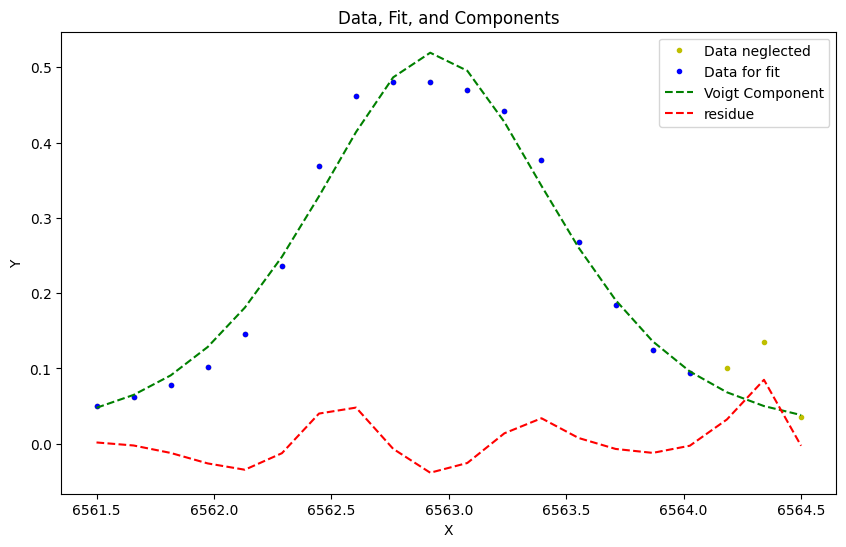

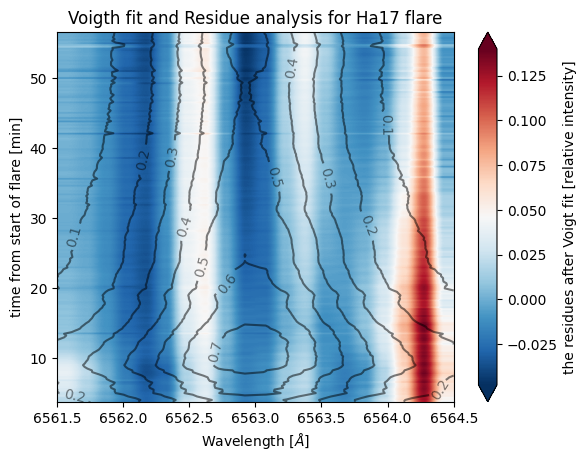

In [10]:
make_analysis('Ha17', data0,[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
              plot_rate=150, offset=0.17, neglect_points=[-3, -2, -1])

the correction factor is 0.739783479304269
param_fit[-1] = (array([ 1.03822793e+00,  8.54204057e+03, -2.89101803e-01, -3.47455548e-04]), array([2.43071487e+00, 6.30952627e-03, 6.80247002e-03, 2.83327370e+02])). Here comes the plot:


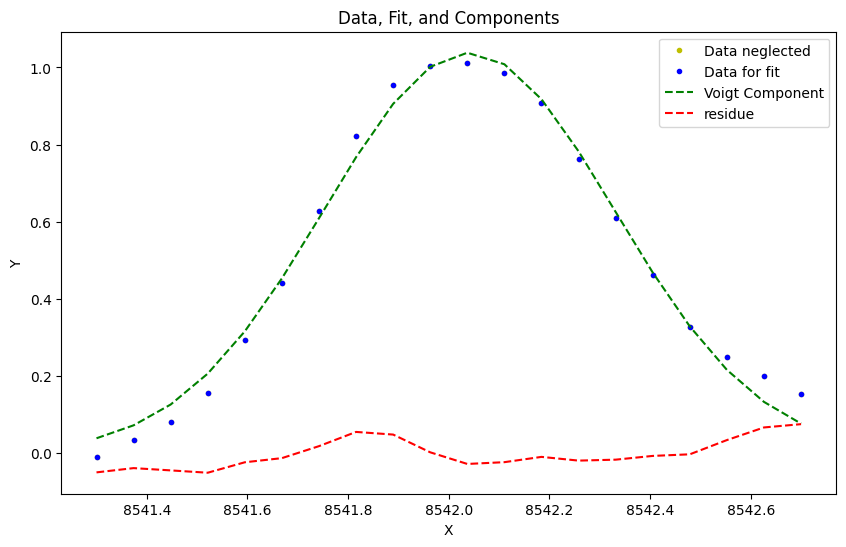

param_fit[-1] = (array([ 8.69865204e-01,  8.54203717e+03, -2.60116301e-01,  2.67864920e-05]), array([3.74082872e-02, 7.51277183e-03, 6.95418666e-03, 8.96184745e+01])). Here comes the plot:


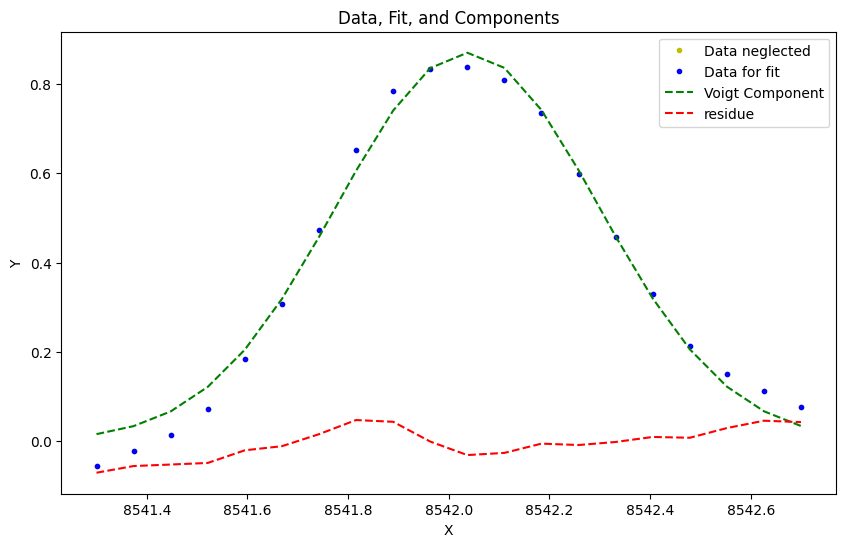

param_fit[-1] = (array([ 7.96332785e-01,  8.54202941e+03, -2.35235253e-01,  2.60127413e-04]), array([3.50157509e+00, 6.66036457e-03, 7.63708543e-03, 6.53391199e+02])). Here comes the plot:


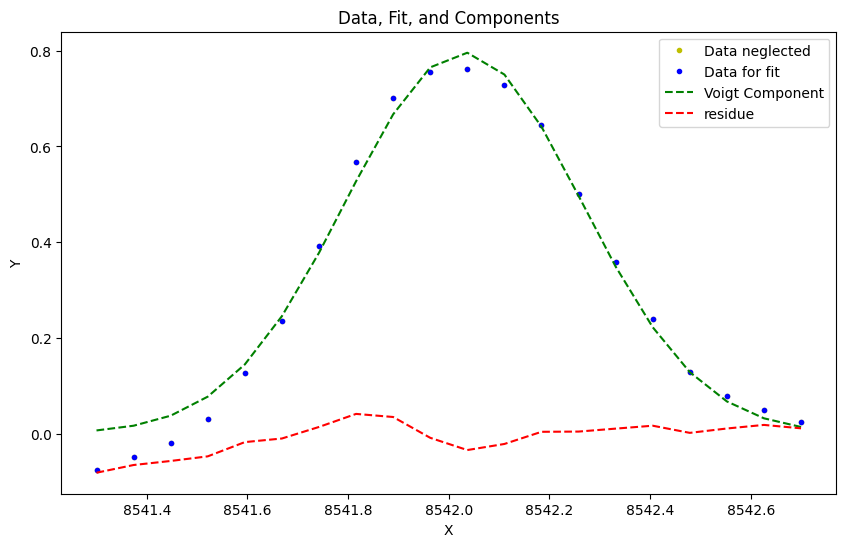

param_fit[-1] = (array([ 8.12400287e-01,  8.54202974e+03, -2.25859263e-01,  1.79001216e-04]), array([3.20108217e+00, 6.81071086e-03, 7.52140097e-03, 5.65620713e+02])). Here comes the plot:


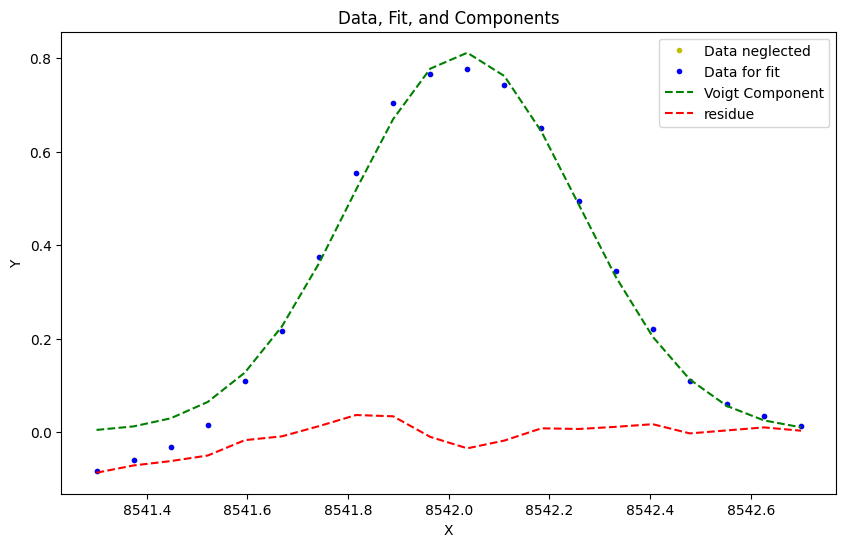

vlim = 0.07208041995374588


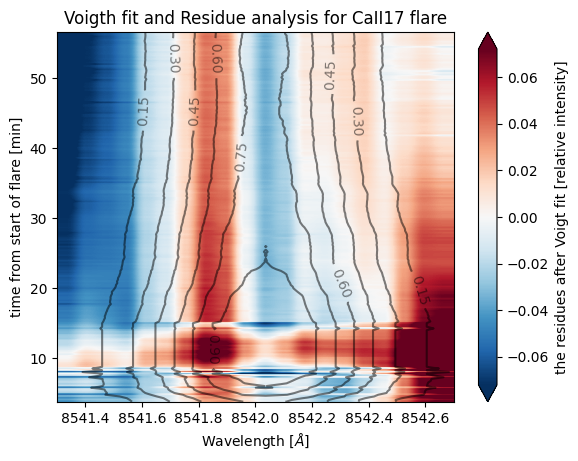

In [24]:
make_analysis('CaII17', data0,[1.5*0.74,  8.54203173e+03, -2.84932183e-01, -2.61301961e-04], plot_rate=50)

the correction factor is 0.09195329098545146
param_fit[-1] = (array([ 6.86949610e-01,  3.93365934e+03, -1.42246528e-01,  3.14979828e-01]), array([0.00953167, 0.00318617, 0.02042127, 0.00825838])). Here comes the plot:


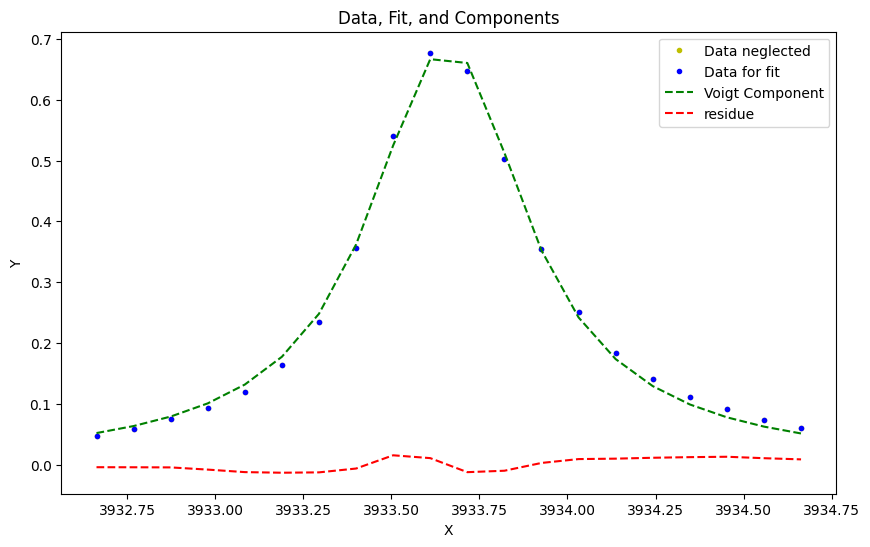

param_fit[-1] = (array([ 6.32425710e-01,  3.93366789e+03, -1.91514878e-01,  3.19626590e-01]), array([0.00860895, 0.00357052, 0.01499817, 0.00573189])). Here comes the plot:


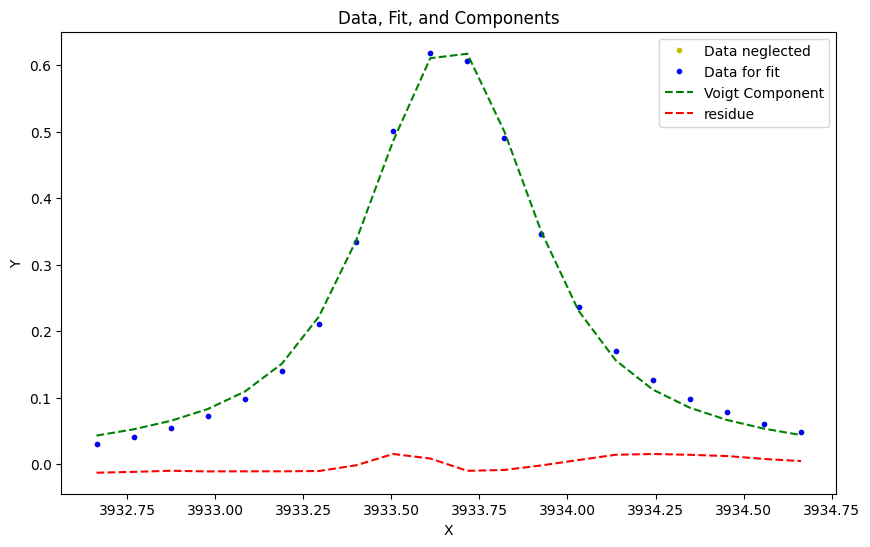

param_fit[-1] = (array([ 5.73015399e-01,  3.93366397e+03, -2.03667920e-01,  3.02872581e-01]), array([0.00847291, 0.00386808, 0.01465193, 0.00634903])). Here comes the plot:


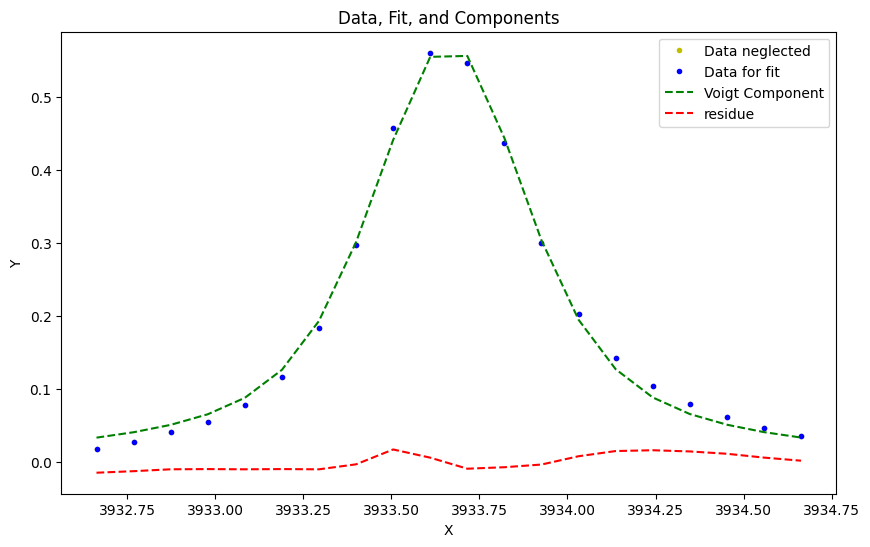

param_fit[-1] = (array([ 5.05216229e-01,  3.93366324e+03, -2.03303210e-01,  2.82635514e-01]), array([0.00704743, 0.00351873, 0.01259893, 0.00623115])). Here comes the plot:


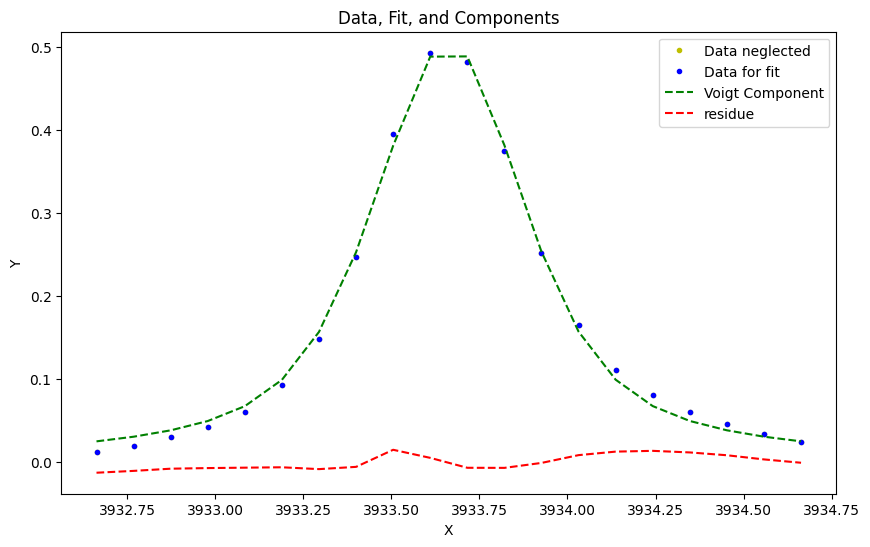

param_fit[-1] = (array([ 4.62358793e-01,  3.93366344e+03, -2.10869528e-01,  2.68493975e-01]), array([0.00564091, 0.00306356, 0.01035222, 0.00636477])). Here comes the plot:


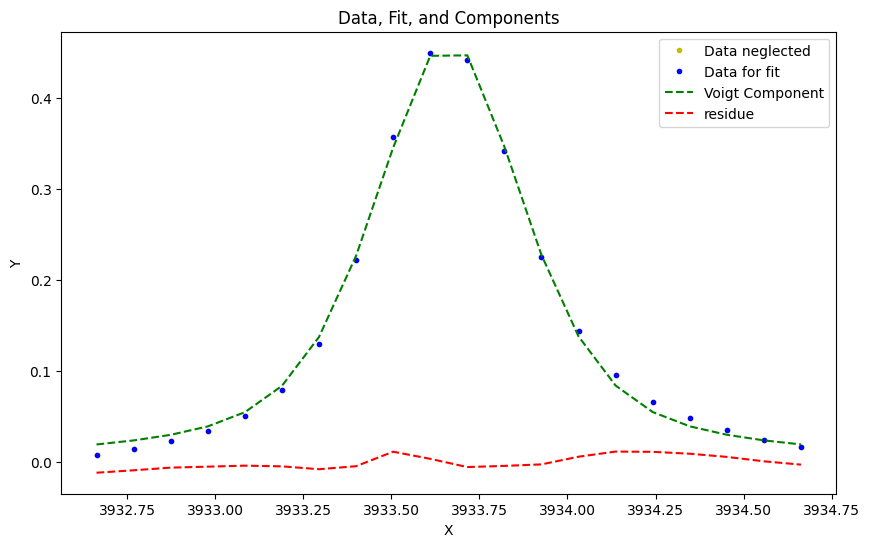

param_fit[-1] = (array([ 4.52683202e-01,  3.93366057e+03, -2.04541355e-01,  2.46923683e-01]), array([0.00427821, 0.00225121, 0.00726449, 0.00516929])). Here comes the plot:


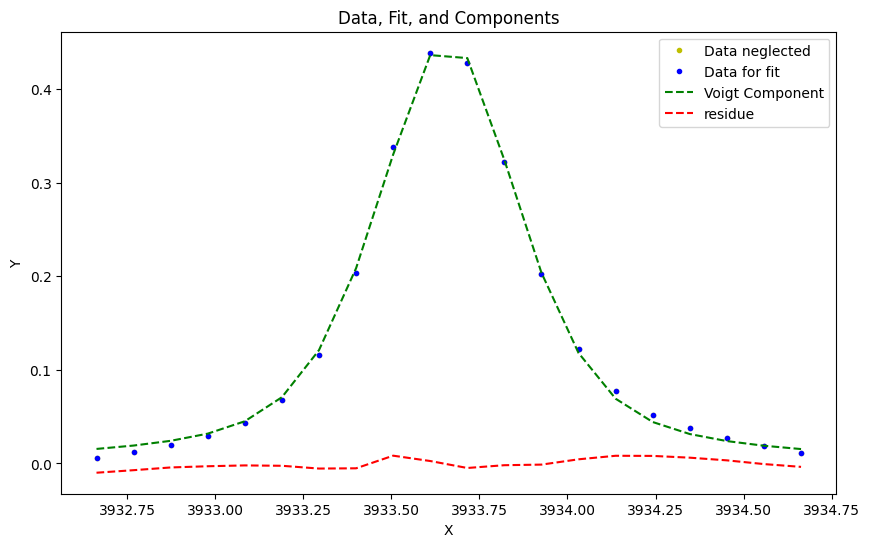

param_fit[-1] = (array([ 4.26647749e-01,  3.93365853e+03, -2.03460880e-01,  2.37027396e-01]), array([0.00389178, 0.0021314 , 0.00669035, 0.00527491])). Here comes the plot:


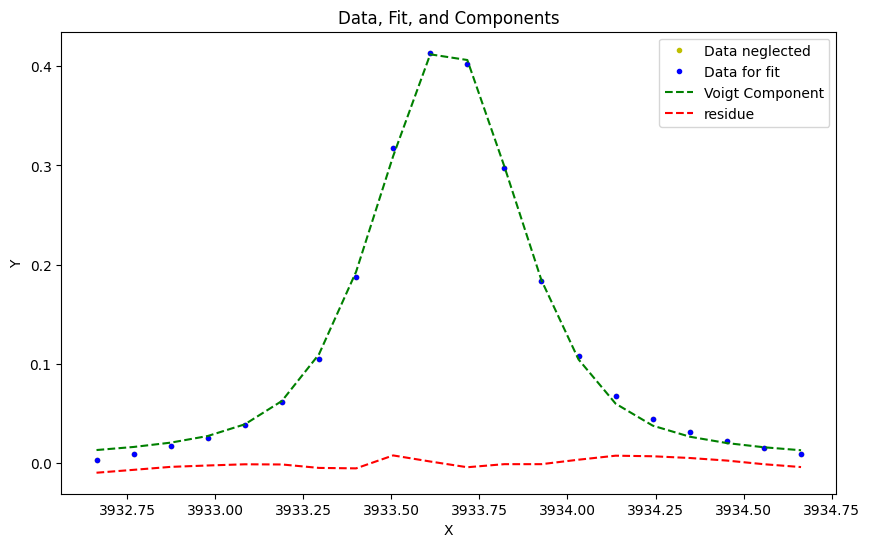

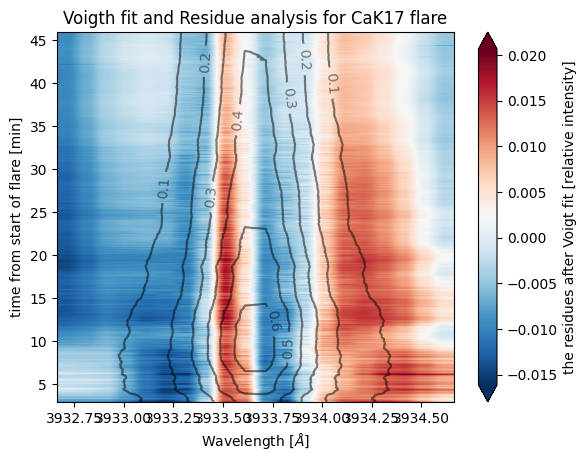

In [12]:
make_analysis('CaK17', data0,[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], plot_rate=50, offset=0.5*0.0919)

# X2.2 flare at 9 o'clock

In [13]:
lines = ["Ha17_9u"]
long_names = {"Ha17_9u":r"H$\alpha$"}

data = un.load_for_further_analysis(lines, full_path="D:/solar flares/data/2017-09-06/")
data.keys()

dict_keys(['FOV_Ha17_9u', 'quiet_sun_Ha17_9u', 'nessi_Ha17_9u', 'TIME_Ha17_9u'])

the correction factor is 0.7178257412287012
param_fit[-1] = (array([ 2.99533245e-01,  6.56298589e+03,  4.53963606e-01, -6.94533980e-04]), array([2.87304206e+00, 1.48090614e-02, 1.48892992e-02, 2.08456827e+03])). Here comes the plot:


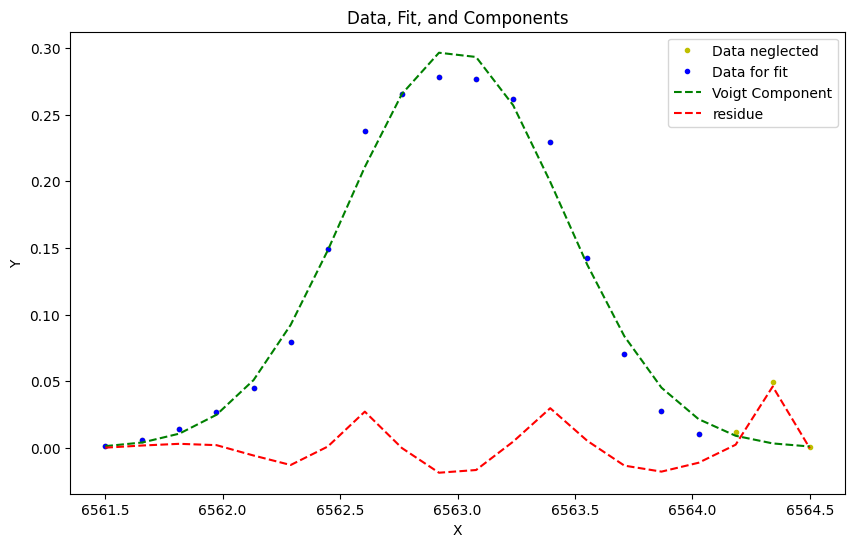

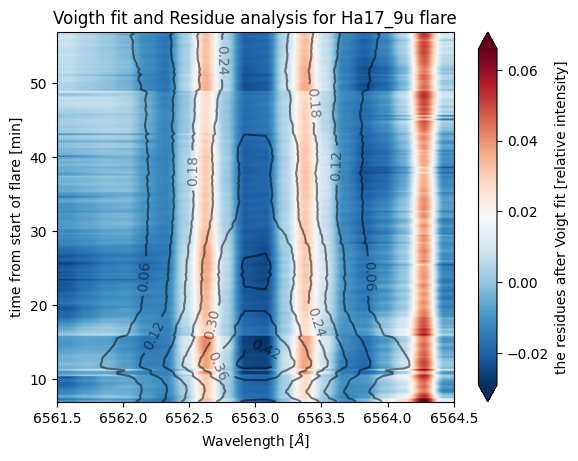

In [14]:
initial_guesses = {'Ha':[5.55265545e-01*0.71, 6.56293638e+03, 5.29257897e-01*0.71, 4.96399919e-01/0.71]}

make_full_analysis(data, lines, init_guesses=initial_guesses, offsets=[0.2*0.71], 
                   plot_rate=150, list_neglect_points=[[-3, -2, -1]])


# the C1.3 flare 2013

dict_keys(['FOV_Ha13', 'quiet_sun_Ha13', 'nessi_Ha13', 'TIME_Ha13'])
the correction factor is 0.8821712151803175
param_fit[-1] = (array([1.47415169e-01, 6.56308140e+03, 3.89841093e-01, 4.44859752e-01]), array([0.01011816, 0.02495639, 1.06671292, 1.3325136 ])). Here comes the plot:


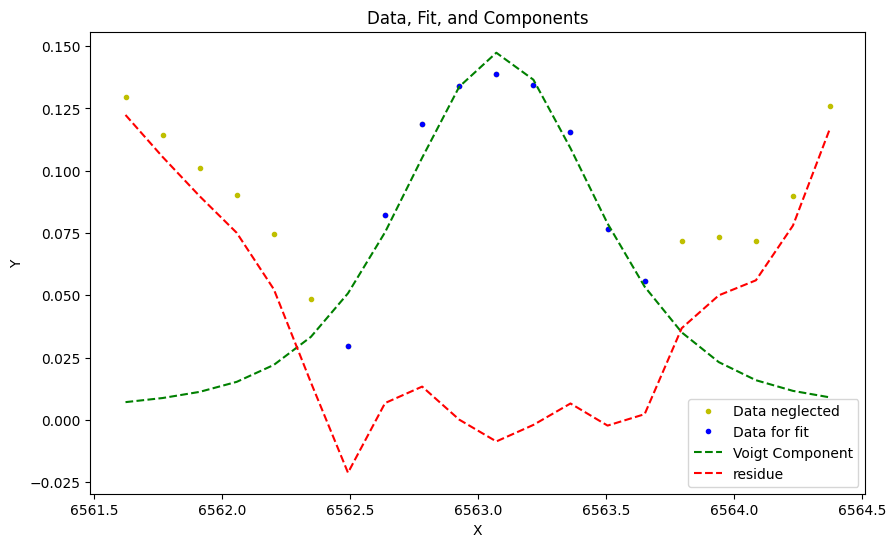

param_fit[-1] = (array([1.36783814e-01, 6.56308390e+03, 3.81919062e-01, 4.25700980e-01]), array([0.01005213, 0.02579521, 0.92814637, 1.23568235])). Here comes the plot:


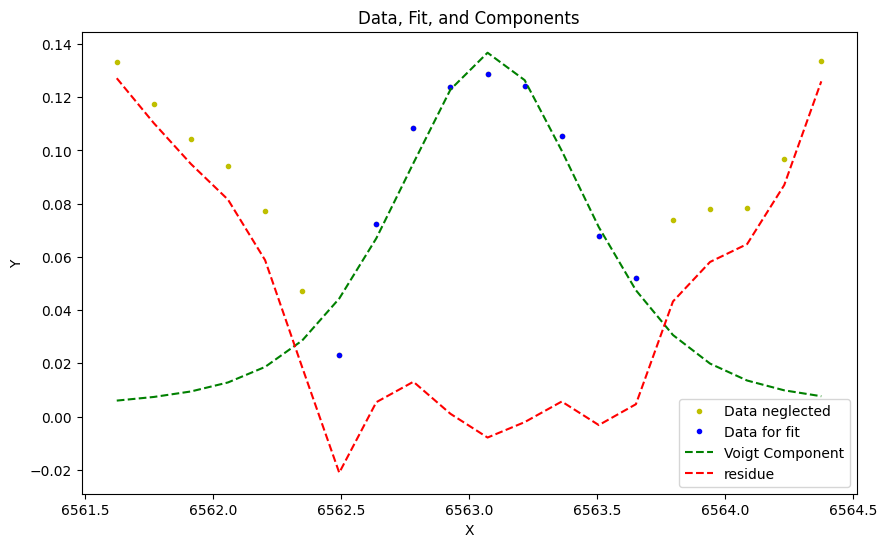

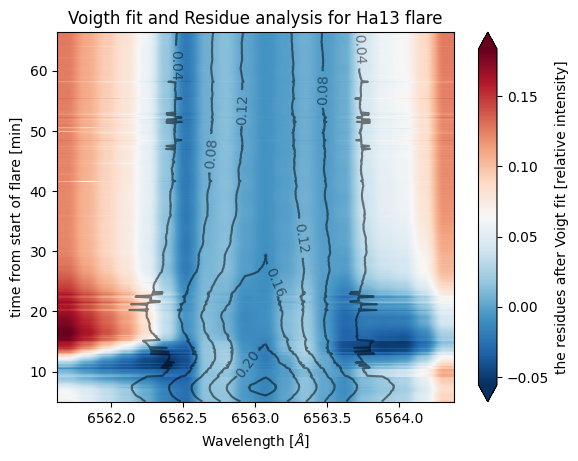

In [16]:
reload(un)
lines = ["Ha13"]
long_names = {"Ha13":r"H$\alpha$ 2013"}

data = un.load_for_further_analysis(lines, full_path = "D:/solar flares/data/2013-06-30/")
print(data.keys())


initial_guesses = {'Ha':[5.55265545e-01*0.88, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01]}
lnp=[[0,1,2,3,4,5,-5,-4,-3, -2, -1]]
make_full_analysis(data, lines, offsets=[0.09*0.88], plot_rate=250, init_guesses=initial_guesses, list_neglect_points=lnp)

# C2.2 flare 2019

dict_keys(['FOV_CaIR19', 'quiet_sun_CaIR19', 'nessi_CaIR19', 'TIME_CaIR19', 'FOV_Fe6173_2019', 'quiet_sun_Fe6173_2019', 'nessi_Fe6173_2019', 'TIME_Fe6173_2019', 'FOV_CaK19', 'quiet_sun_CaK19', 'nessi_CaK19', 'TIME_CaK19'])
the correction factor is 0.6934060535332651
param_fit[-1] = (array([ 2.17650448e-01,  8.54196653e+03, -2.73609611e-01,  3.22680935e-04]), array([4.03694507e-01, 4.38561402e-03, 4.56697538e-03, 2.15771211e+02])). Here comes the plot:


c:\Users\Gebruiker\Anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


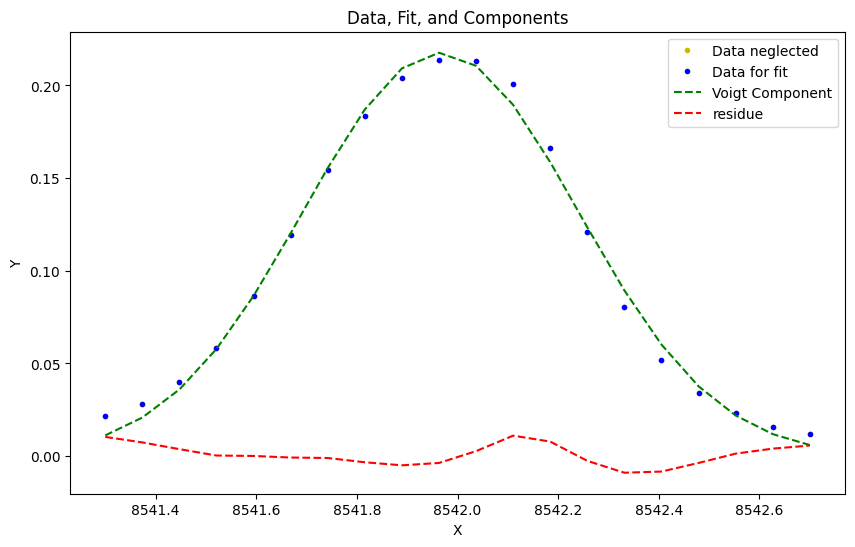

param_fit[-1] = (array([ 2.40164464e-01,  8.54196662e+03, -2.52162356e-01, -1.92634373e-04]), array([7.10739425e-01, 3.64616188e-03, 3.63818745e-03, 4.92229751e+02])). Here comes the plot:


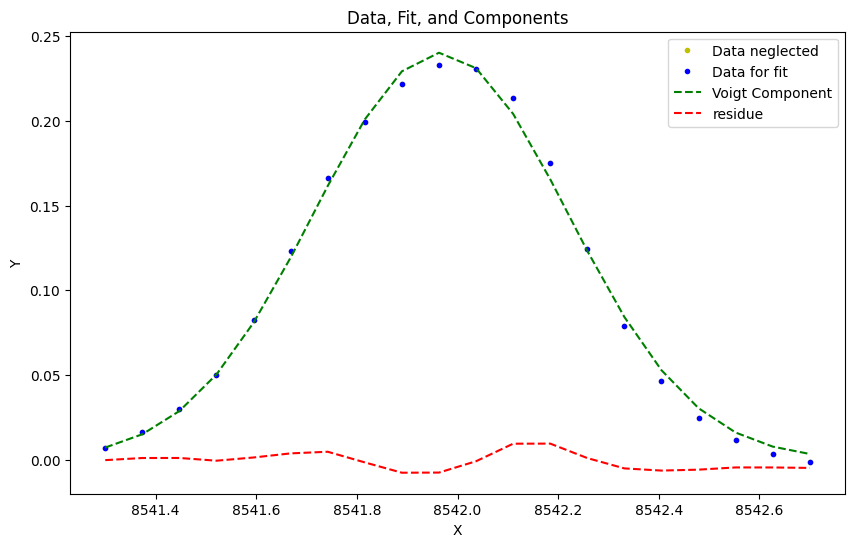

param_fit[-1] = (array([ 2.09813042e-01,  8.54195313e+03, -2.62030041e-01, -3.02548869e-04]), array([2.38678497e+00, 5.26272060e-03, 5.07614320e-03, 1.28869732e+03])). Here comes the plot:


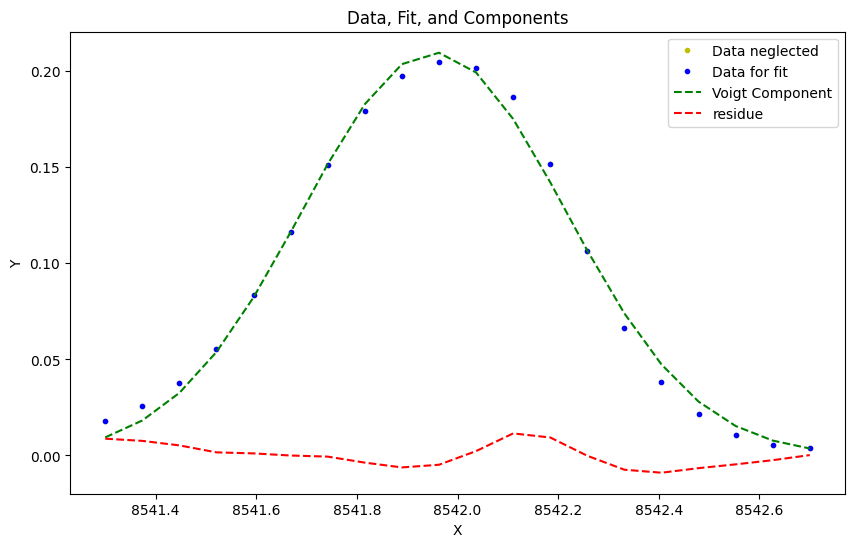

param_fit[-1] = (array([ 2.04599361e-01,  8.54195395e+03, -2.66310079e-01, -1.23308777e-04]), array([2.86525121e-01, 4.33836120e-03, 4.23478960e-03, 3.95839081e+02])). Here comes the plot:


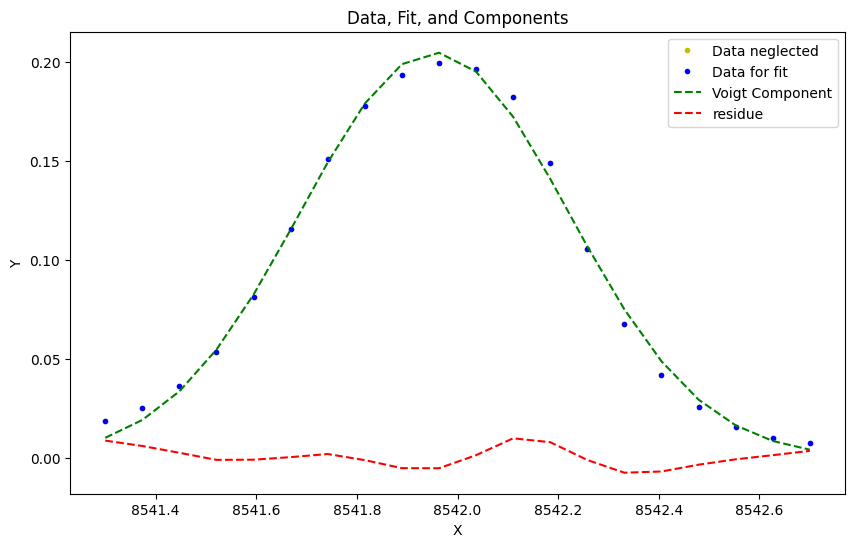

param_fit[-1] = (array([ 1.95548137e-01,  8.54195297e+03, -2.67873882e-01,  1.14557521e-03]), array([8.49023899e-01, 5.58148035e-03, 5.35399678e-03, 5.05857714e+02])). Here comes the plot:


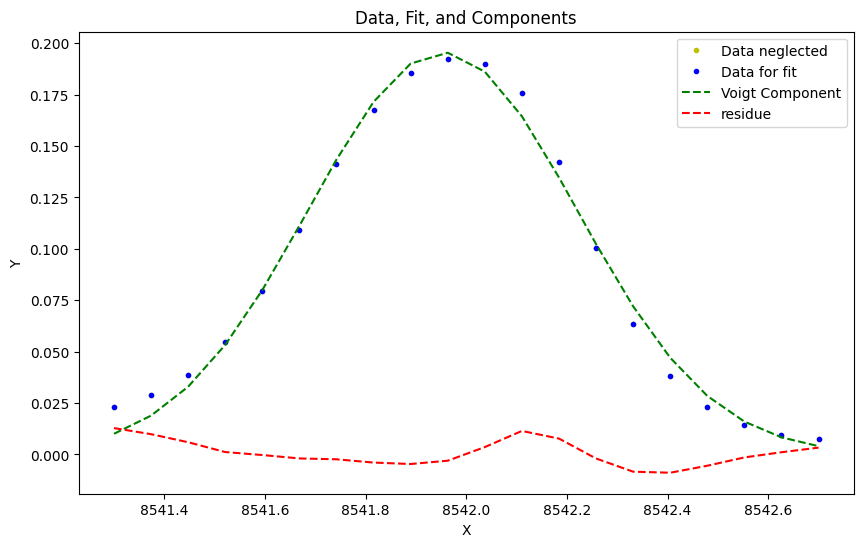

param_fit[-1] = (array([ 1.94863411e-01,  8.54194311e+03, -2.84528920e-01, -9.86833760e-05]), array([1.32885210e-01, 5.96213362e-03, 6.36662097e-03, 2.76522447e+02])). Here comes the plot:


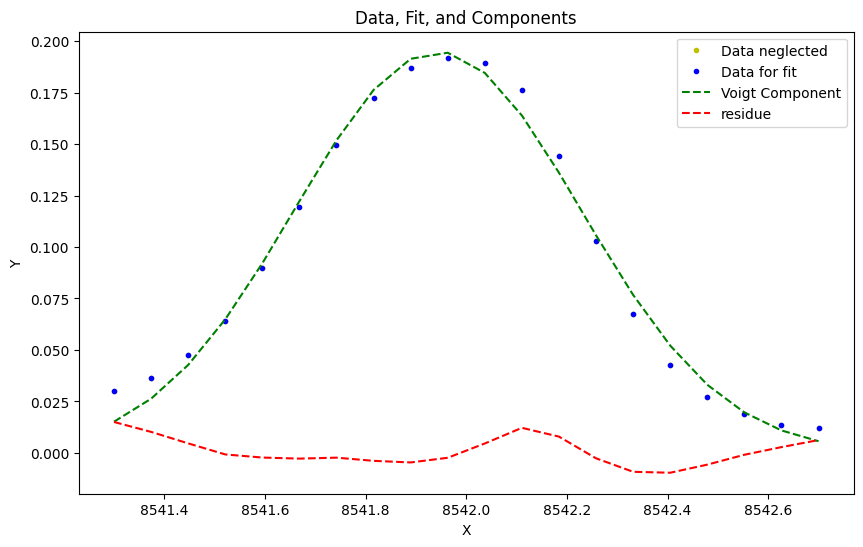

vlim = 0.013513784076394891


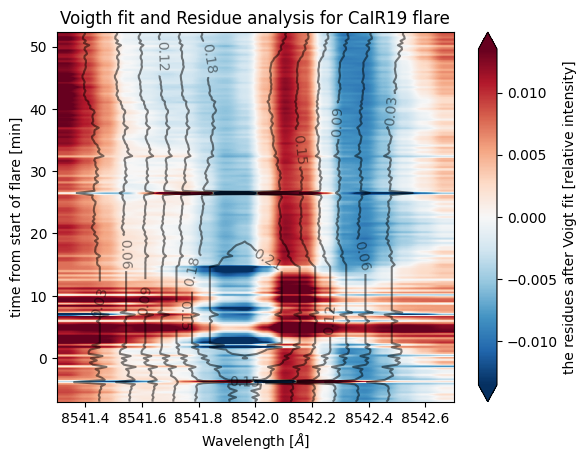

the correction factor is 0.7912546190700971
param_fit[-1] = (array([ 3.86290978e-02,  6.17295462e+03, -3.72256518e-02,  4.38271873e-02]), array([0.00458769, 0.00525182, 0.02531554, 0.02259564])). Here comes the plot:


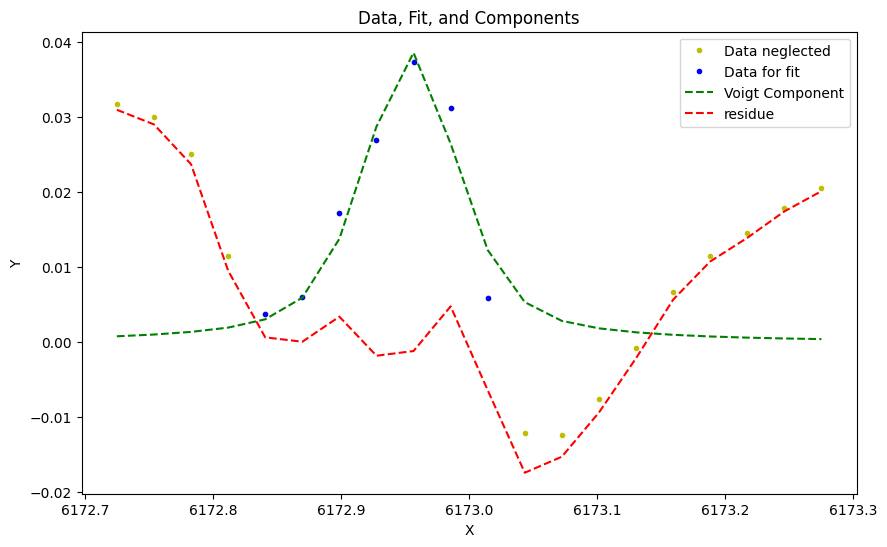

param_fit[-1] = (array([ 3.17069257e-02,  6.17296115e+03, -2.64740012e-02, -1.03777881e-04]), array([1.83308748e+01, 8.38836935e-03, 1.20251206e-02, 1.95437172e+03])). Here comes the plot:


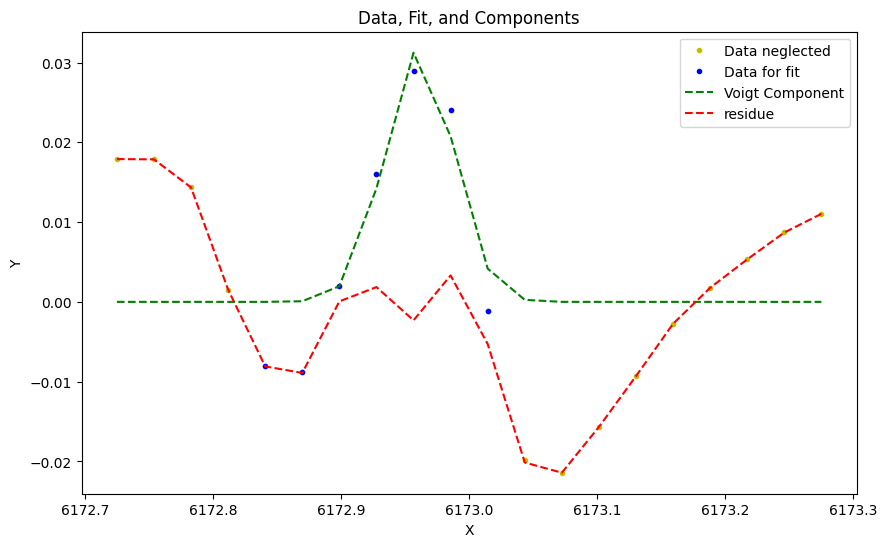

param_fit[-1] = (array([ 4.30293306e-02,  6.17294962e+03,  3.82607420e-02, -4.82699197e-02]), array([0.0050987 , 0.00545557, 0.02977714, 0.02183942])). Here comes the plot:


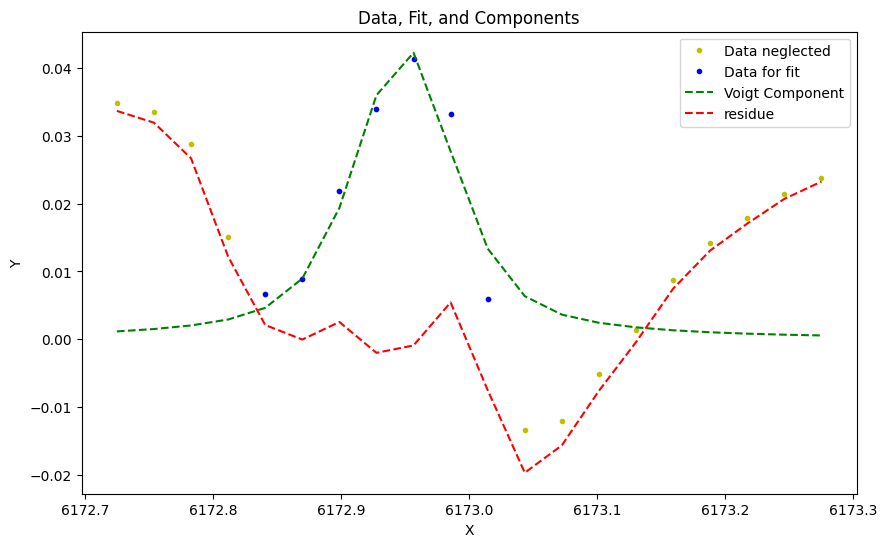

param_fit[-1] = (array([ 4.33739301e-02,  6.17294303e+03,  4.19941524e-02, -4.55700631e-02]), array([0.00621442, 0.00675448, 0.04390071, 0.05388789])). Here comes the plot:


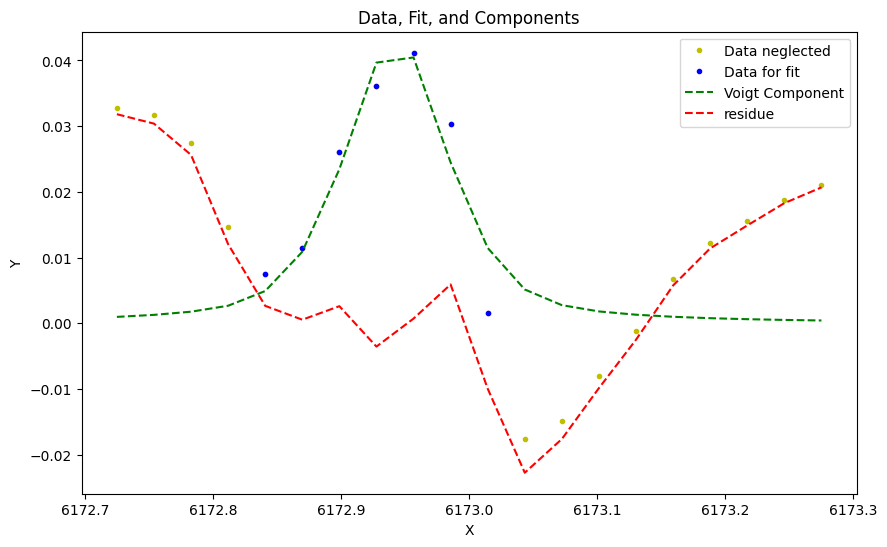

param_fit[-1] = (array([ 4.04403436e-02,  6.17294451e+03,  4.10756160e-02, -4.60212271e-04]), array([5.54561811e+00, 6.08531813e-03, 8.92345234e-03, 2.51991128e+02])). Here comes the plot:


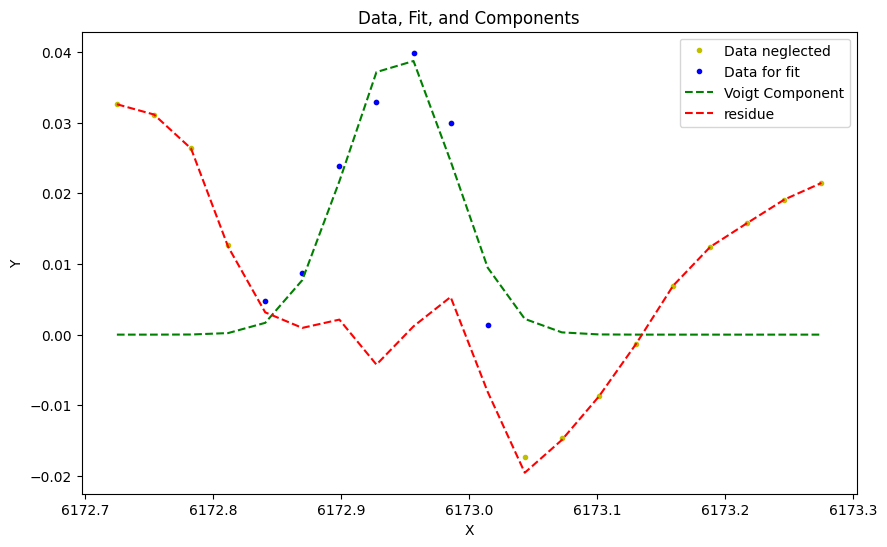

param_fit[-1] = (array([4.41876318e-02, 6.17294434e+03, 4.02240778e-02, 5.86237950e-02]), array([0.00597394, 0.00694702, 0.04677833, 0.02207143])). Here comes the plot:


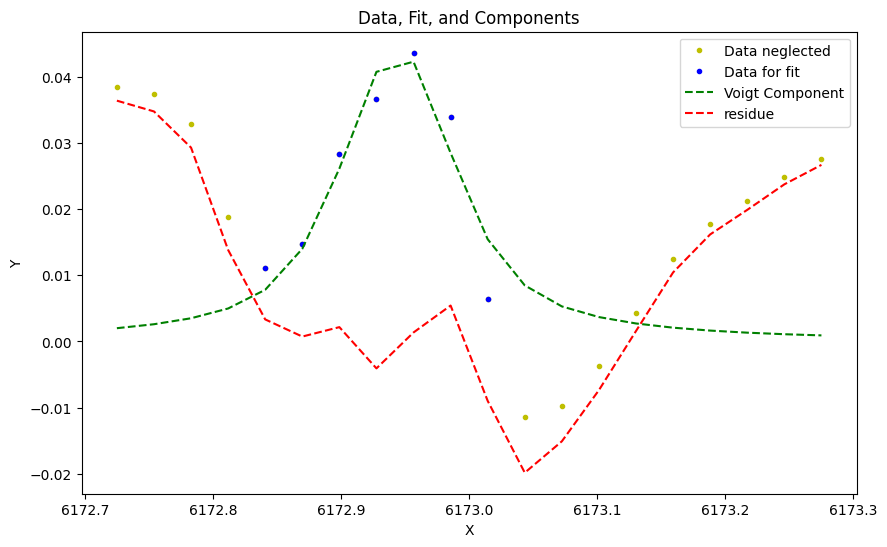

vlim = 0.03199437173080104


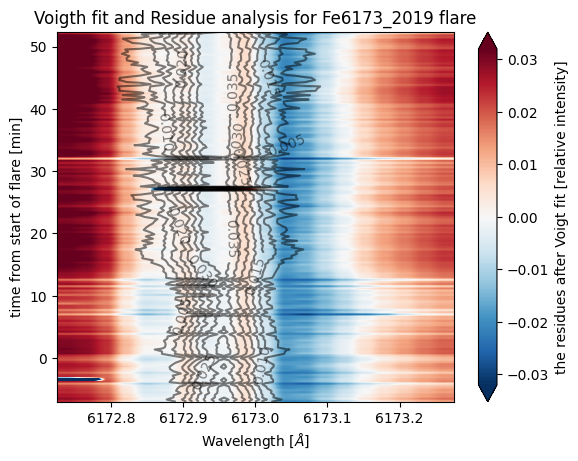

the correction factor is 0.12995492392730582
param_fit[-1] = (array([ 1.69011026e-01,  3.93366699e+03, -2.29532121e-01,  3.11568621e-01]), array([0.00574465, 0.0095742 , 0.03236751, 0.01689323])). Here comes the plot:


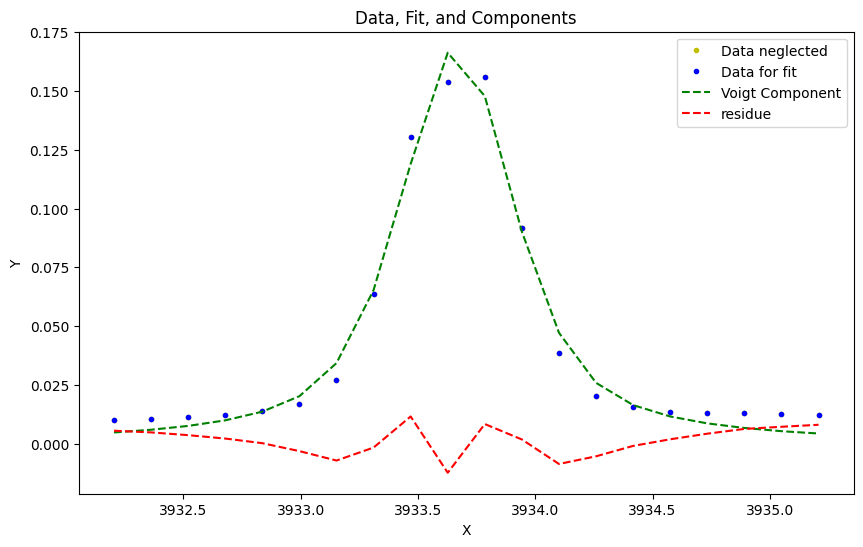

param_fit[-1] = (array([ 1.84968432e-01,  3.93367076e+03, -2.40965953e-01,  3.09300595e-01]), array([0.00499893, 0.00778447, 0.0253315 , 0.01514916])). Here comes the plot:


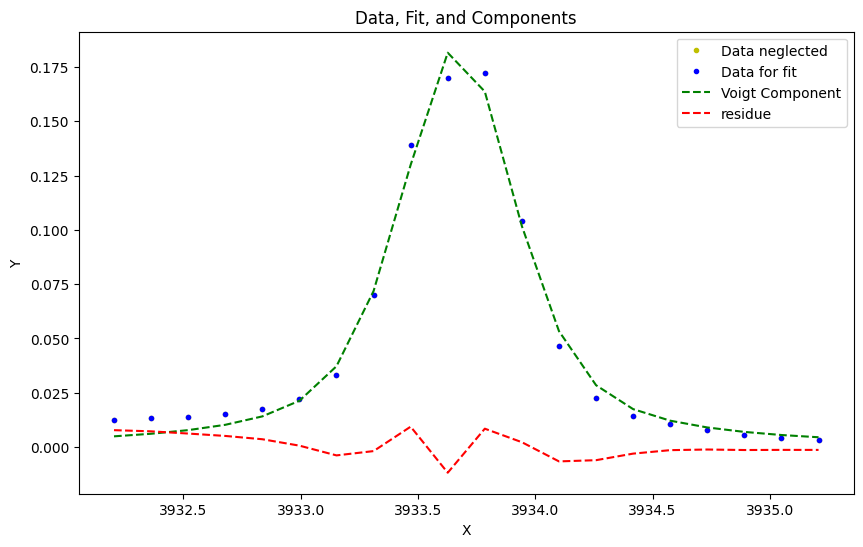

param_fit[-1] = (array([ 1.99822028e-01,  3.93368334e+03, -2.19396408e-01,  3.34169909e-01]), array([0.00569342, 0.00812628, 0.03026474, 0.01279135])). Here comes the plot:


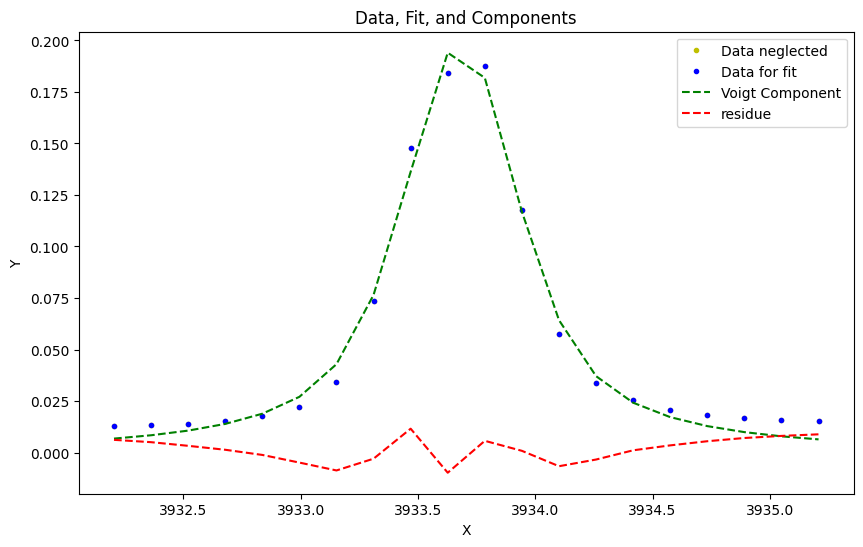

param_fit[-1] = (array([ 1.95582582e-01,  3.93368044e+03, -2.18395086e-01,  3.30600358e-01]), array([0.00612541, 0.00886561, 0.03279874, 0.0139908 ])). Here comes the plot:


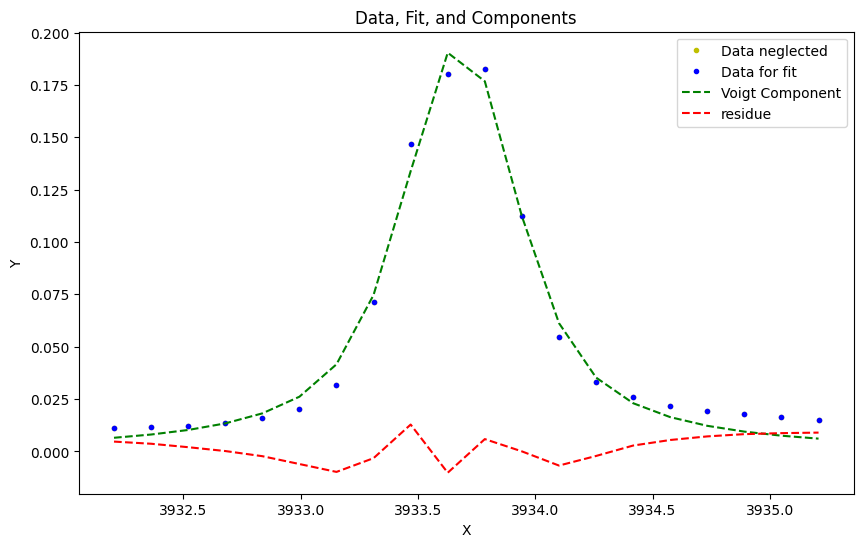

param_fit[-1] = (array([ 1.96986927e-01,  3.93367494e+03, -2.27725746e-01,  3.13933779e-01]), array([0.00569008, 0.00812902, 0.02780324, 0.01404198])). Here comes the plot:


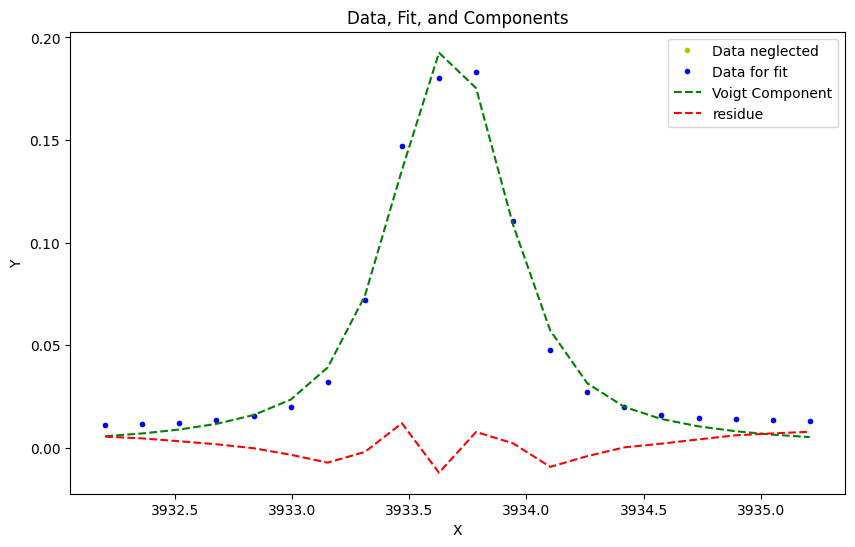

param_fit[-1] = (array([ 1.95709193e-01,  3.93367241e+03, -2.28020613e-01,  3.19931485e-01]), array([0.00601515, 0.00873832, 0.03032136, 0.01474734])). Here comes the plot:


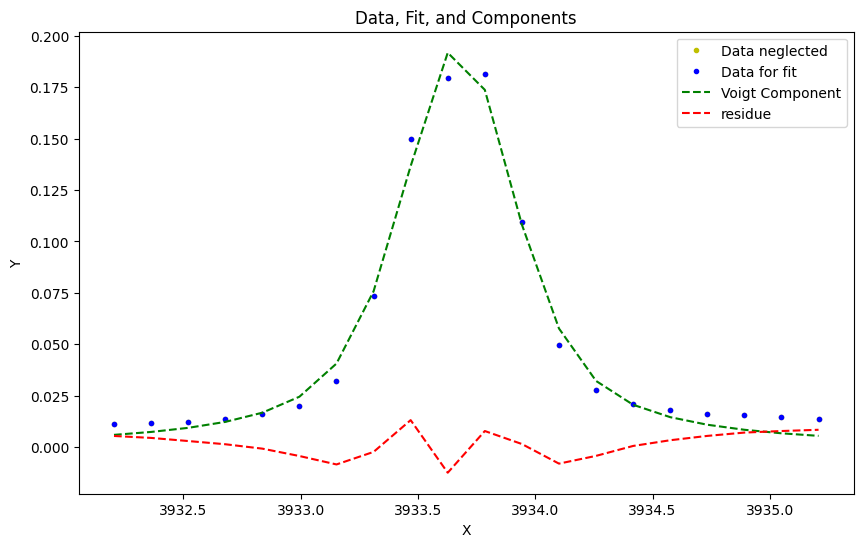

param_fit[-1] = (array([ 1.80719025e-01,  3.93366644e+03, -2.31628015e-01,  3.23516136e-01]), array([0.00624958, 0.00996806, 0.03450382, 0.01692381])). Here comes the plot:


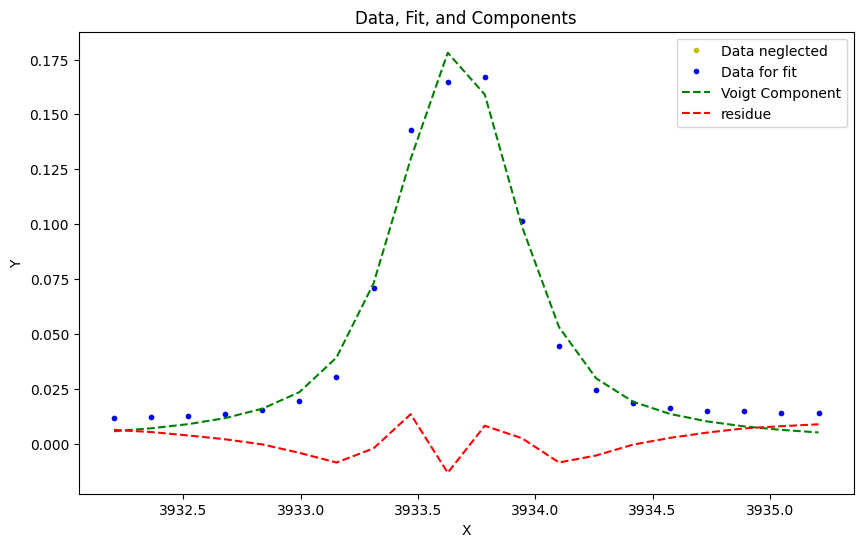

param_fit[-1] = (array([ 1.75889139e-01,  3.93366209e+03, -2.29384194e-01,  3.24080850e-01]), array([0.00632495, 0.0103275 , 0.03605284, 0.01727391])). Here comes the plot:


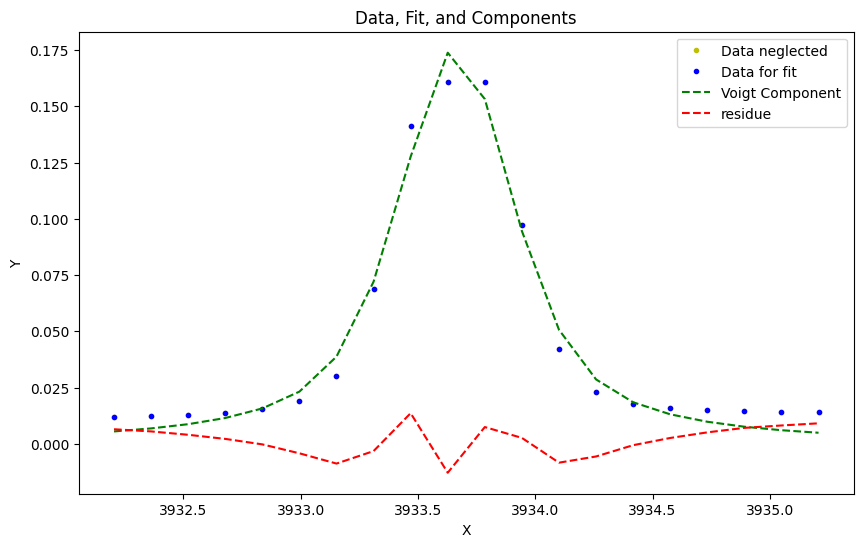

param_fit[-1] = (array([ 1.73550872e-01,  3.93366214e+03, -2.29482253e-01,  3.23766320e-01]), array([0.00597028, 0.00987699, 0.03444138, 0.01654792])). Here comes the plot:


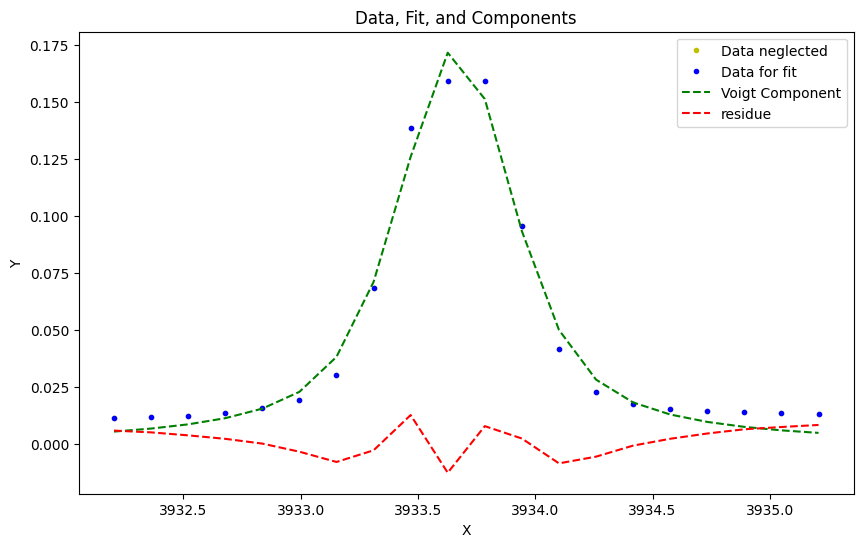

param_fit[-1] = (array([ 1.74276867e-01,  3.93366469e+03, -2.27586591e-01,  3.12555068e-01]), array([0.00607174, 0.0097878 , 0.03337051, 0.01696747])). Here comes the plot:


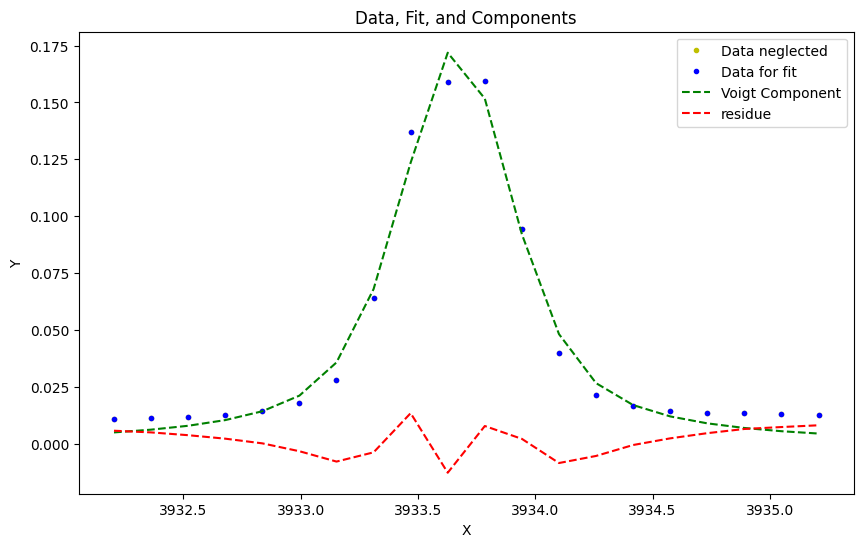

param_fit[-1] = (array([ 1.71817212e-01,  3.93366574e+03, -2.30412044e-01,  3.06442138e-01]), array([0.00581496, 0.00947894, 0.03154872, 0.01726728])). Here comes the plot:


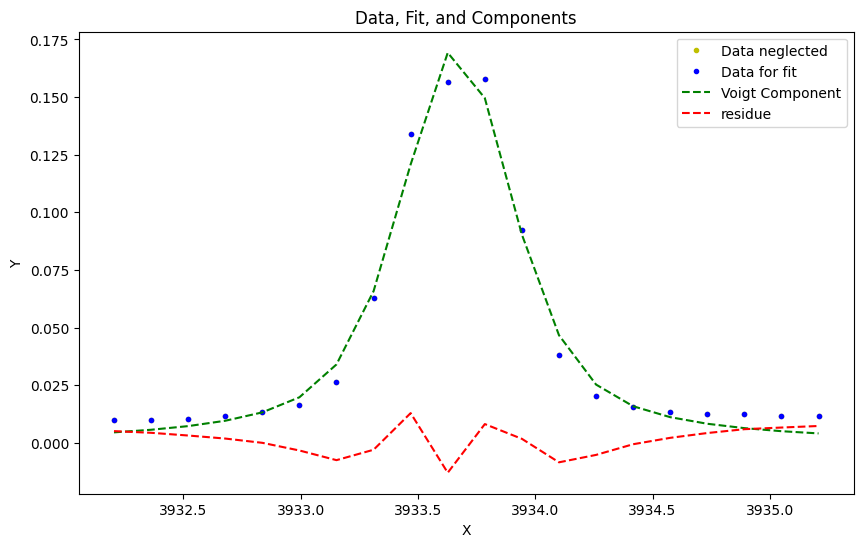

param_fit[-1] = (array([ 1.66910179e-01,  3.93366526e+03, -2.31881685e-01,  3.10829950e-01]), array([0.0058001 , 0.00983103, 0.03293975, 0.0176922 ])). Here comes the plot:


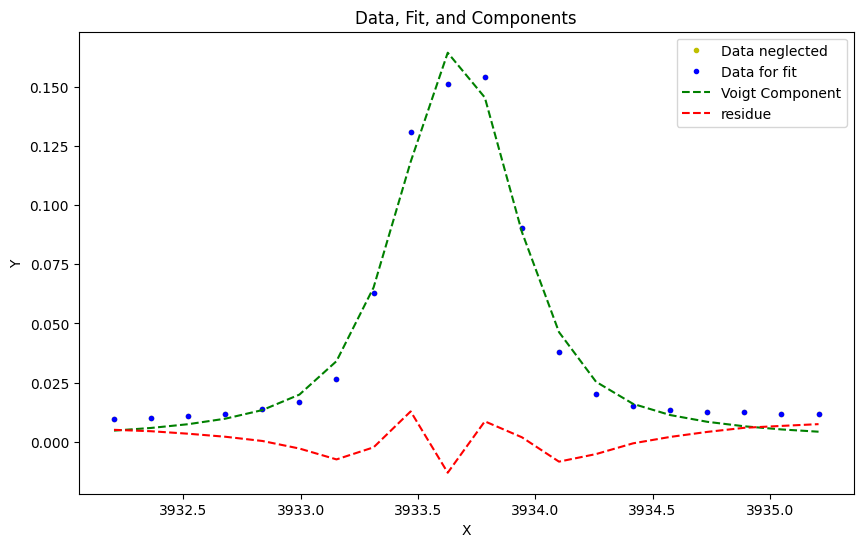

param_fit[-1] = (array([ 1.67467279e-01,  3.93366272e+03, -2.30356731e-01,  3.18814586e-01]), array([0.0060301 , 0.01027907, 0.03529616, 0.01764747])). Here comes the plot:


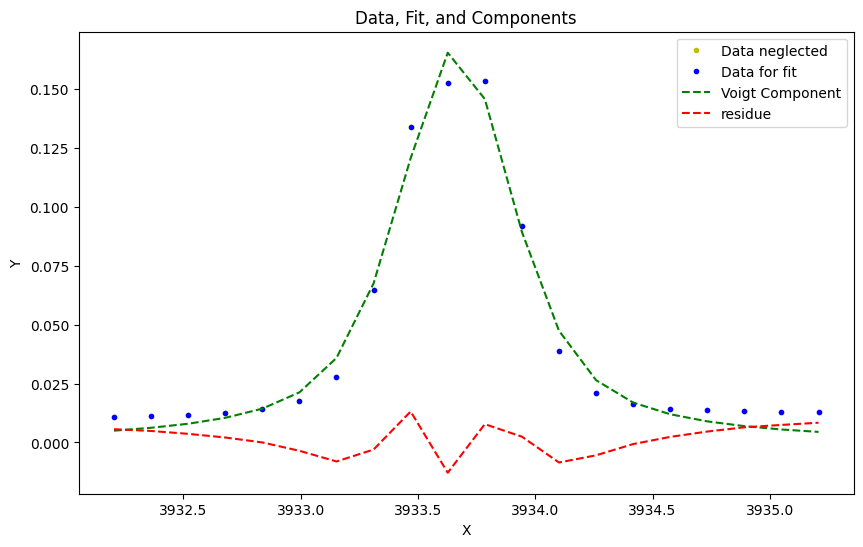

param_fit[-1] = (array([ 1.65029517e-01,  3.93366135e+03, -2.32469859e-01,  3.11915418e-01]), array([0.00588566, 0.01012385, 0.0339455 , 0.0181938 ])). Here comes the plot:


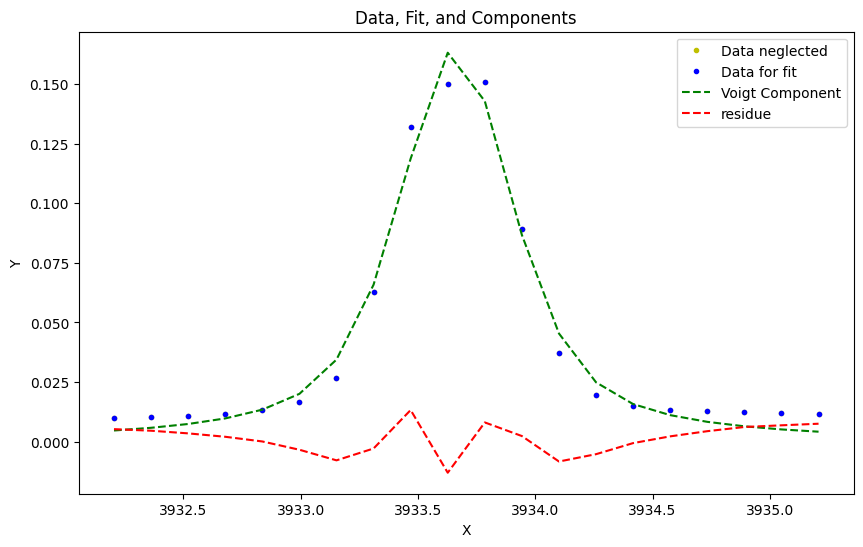

param_fit[-1] = (array([ 1.69032529e-01,  3.93365686e+03, -2.26570088e-01,  3.27529139e-01]), array([0.00647425, 0.01099676, 0.03909597, 0.01793287])). Here comes the plot:


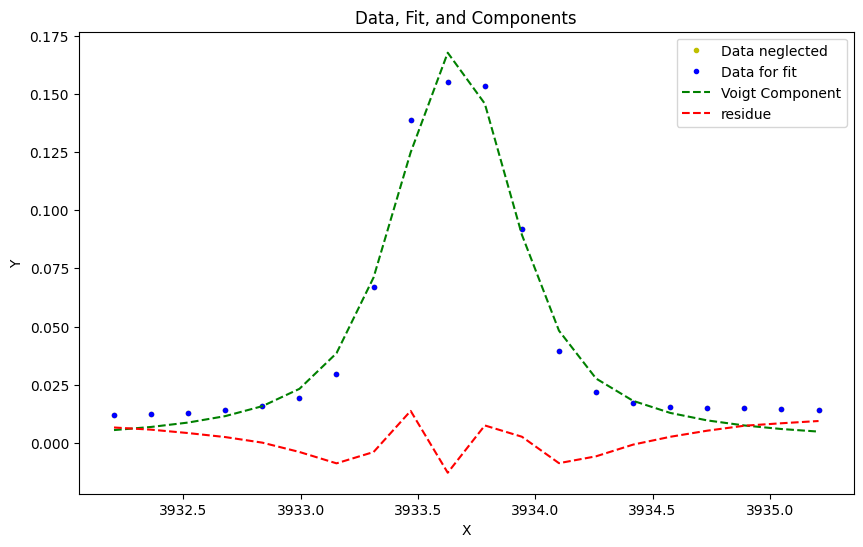

param_fit[-1] = (array([ 1.64900316e-01,  3.93365539e+03, -2.32049830e-01,  3.25904146e-01]), array([0.00575303, 0.01011017, 0.03514798, 0.01703927])). Here comes the plot:


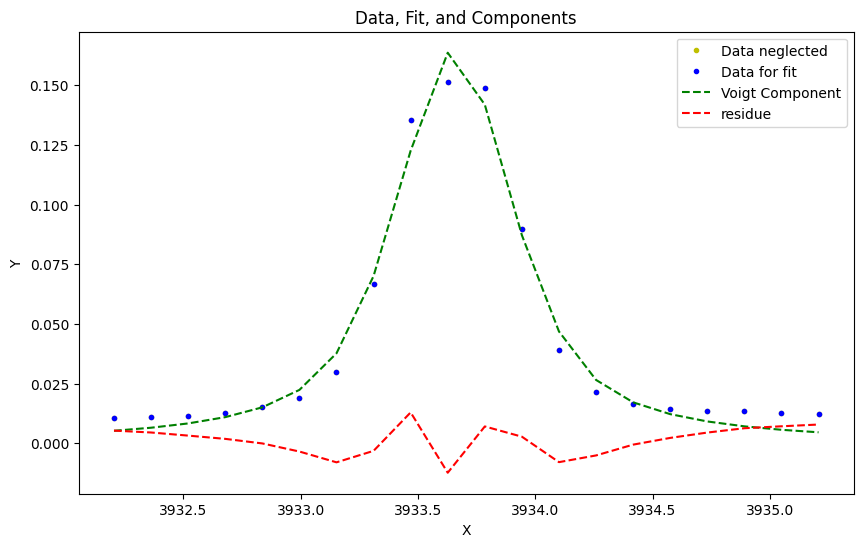

param_fit[-1] = (array([ 1.70058432e-01,  3.93366037e+03, -2.31474527e-01,  3.29990138e-01]), array([0.00578767, 0.00990868, 0.03487711, 0.01641725])). Here comes the plot:


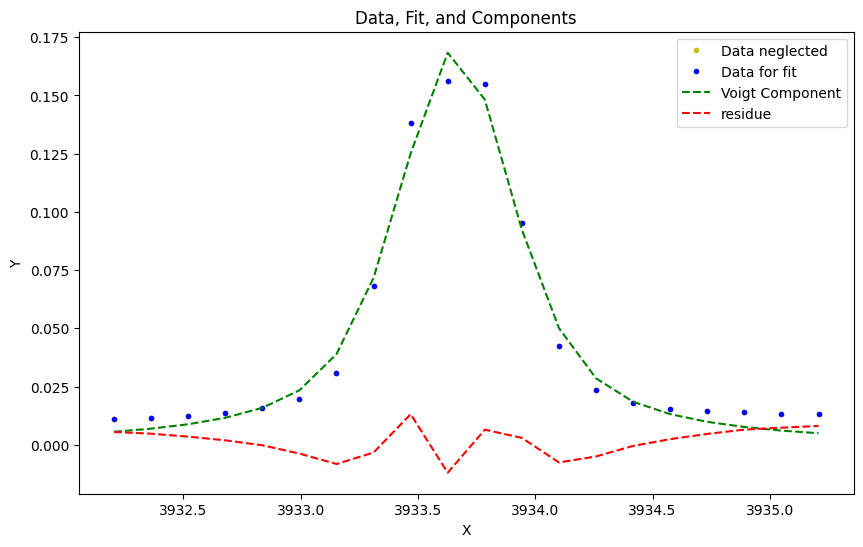

param_fit[-1] = (array([ 1.73637684e-01,  3.93366514e+03, -2.36118558e-01,  3.23462691e-01]), array([0.00524579, 0.00879265, 0.03001841, 0.01533982])). Here comes the plot:


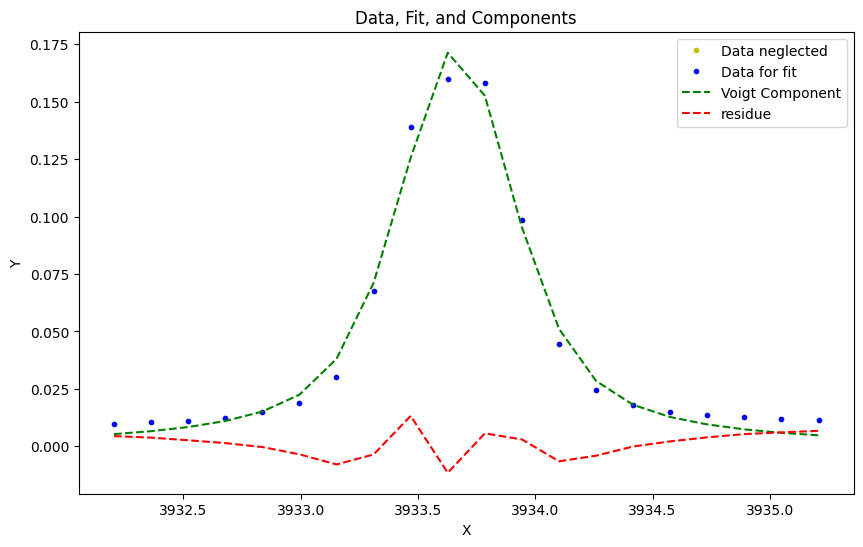

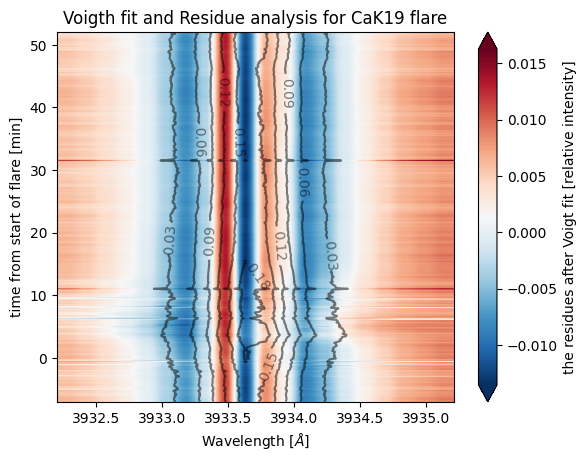

In [17]:
c1 = 0.6934060535332651
c2 = 0.7912546190700971
c3 = 0.12995492392730582

reload(un)
lines = ["CaIR19", "Fe6173_2019", "CaK19"]
offsets = [0.05*c1, 0.01, 0.05*c3]
long_names = {"Fe6173_2019":r"Fe 6173", "CaK19":r'Ca$IIK$', "CaIR19":r'Ca$II 8542 \AA$'}

data = un.load_for_further_analysis(lines, full_path = "D:/solar flares/data/2019-05-06/")
un2.disgard_cont_point("CaK19", data)

print(data.keys())

initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5*c3, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[ 2.40164464e-01,  8.54196662e+03, -2.52162356e-01,  -1.92634373e-04],
                   "Fe6173":[4.13090273e-02*c2, 6.1728106e+03, -1.55441909e-03, 4.25981451e-02]}
lnp=[[], [0,1,2,3,-9, -8, -7,-6,-5,-4,-3, -2, -1], []]

make_full_analysis(data, lines, offsets=offsets, init_guesses=initial_guesses, plot_rate=25, list_neglect_points=lnp)

# C5.6

dict_keys(['FOV_CaIR15', 'quiet_sun_CaIR15', 'nessi_CaIR15', 'TIME_CaIR15', 'FOV_Ha15', 'quiet_sun_Ha15', 'nessi_Ha15', 'TIME_Ha15'])
the correction factor is 0.9533701253460637


c:\Users\Gebruiker\Anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


param_fit[-1] = (array([ 1.01296350e-01,  8.54439271e+03, -3.26729226e-01,  3.45144618e-01]), array([0.00916509, 0.0323763 , 0.48639715, 0.72913337])). Here comes the plot:


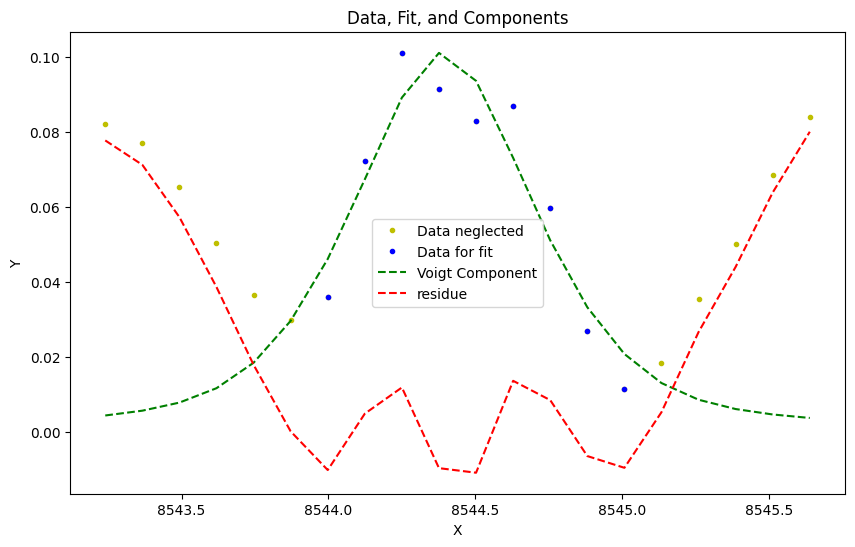

param_fit[-1] = (array([ 1.07786692e-01,  8.54440649e+03, -3.73128896e-01, -1.13879554e-04]), array([1.85107972e-01, 2.82366297e-02, 3.24055067e-02, 1.01036910e+03])). Here comes the plot:


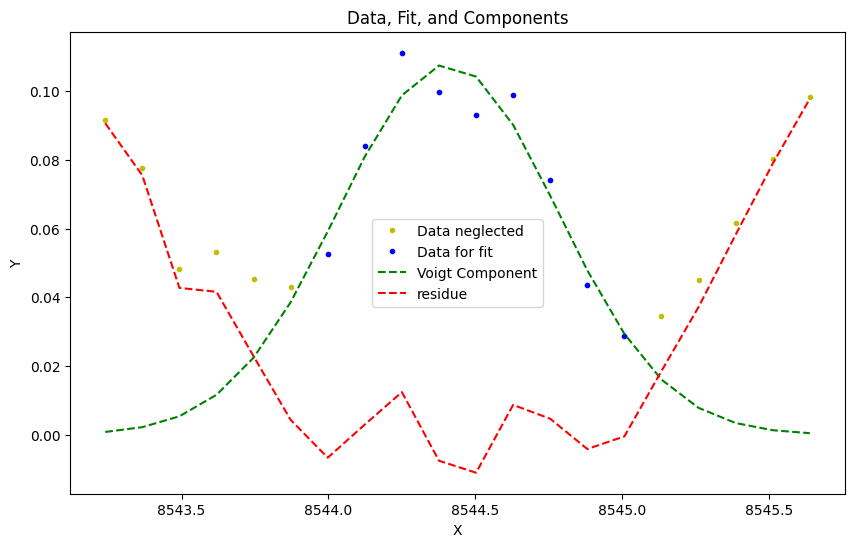

param_fit[-1] = (array([ 1.20000000e-01,  8.54440000e+03, -2.62017731e-01,  4.46885934e-04]), array([2.09983958e+01, 5.69533883e-02, 7.10836943e-02, 1.34434735e+04])). Here comes the plot:


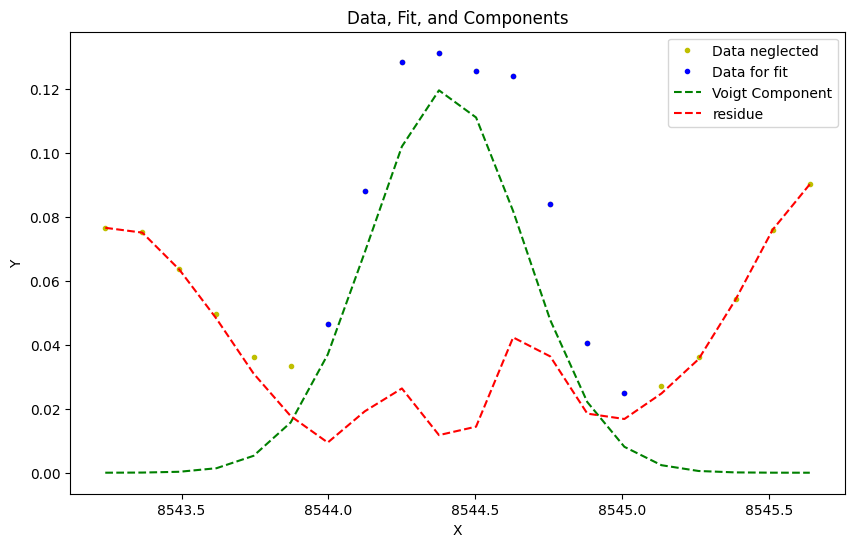

param_fit[-1] = (array([ 1.20000000e-01,  8.54440000e+03, -2.62017731e-01,  4.46885934e-04]), array([1.69305484e+01, 4.59202745e-02, 5.73132319e-02, 1.08391794e+04])). Here comes the plot:


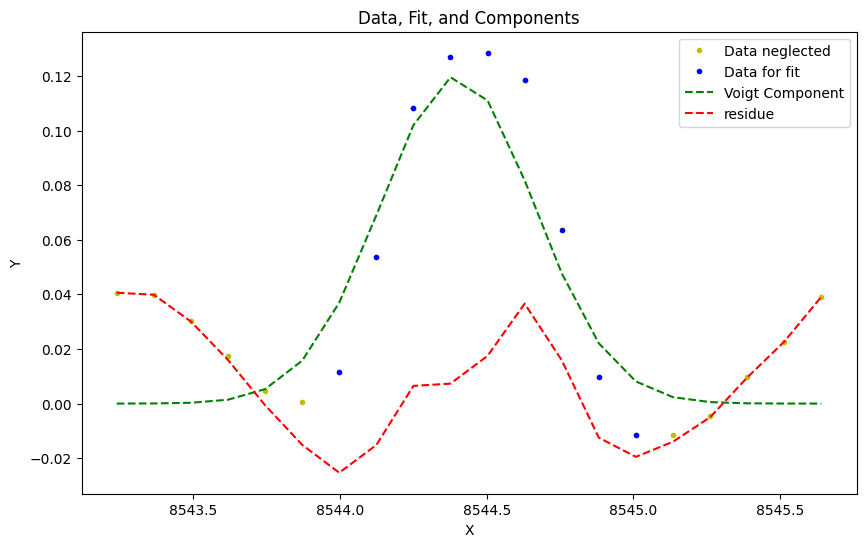

param_fit[-1] = (array([ 9.95257722e-02,  8.54443802e+03, -2.34341789e-01,  2.81401218e-04]), array([5.31383056e+00, 3.11211159e-02, 2.93197684e-02, 5.21629691e+03])). Here comes the plot:


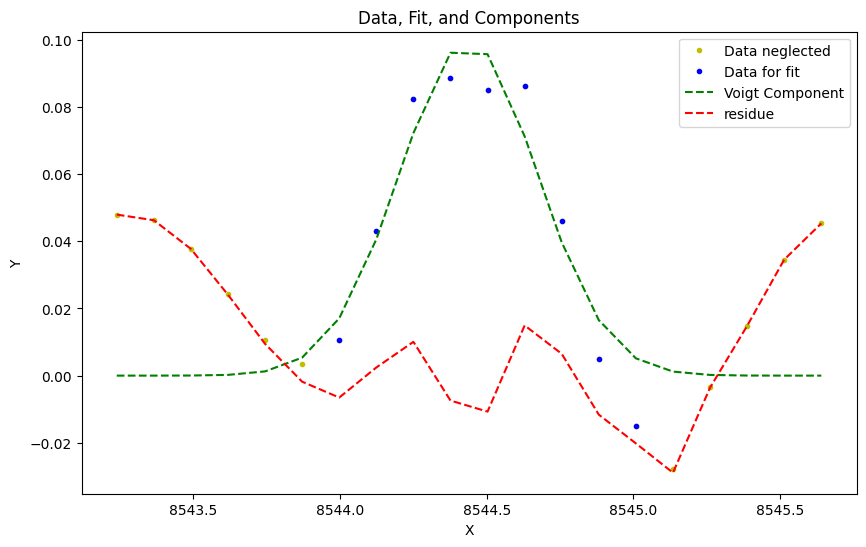

param_fit[-1] = (array([ 8.69150146e-02,  8.54443875e+03, -2.45353226e-01, -4.00808564e-04]), array([8.91165555e+00, 2.63563360e-02, 2.54401919e-02, 7.68761701e+03])). Here comes the plot:


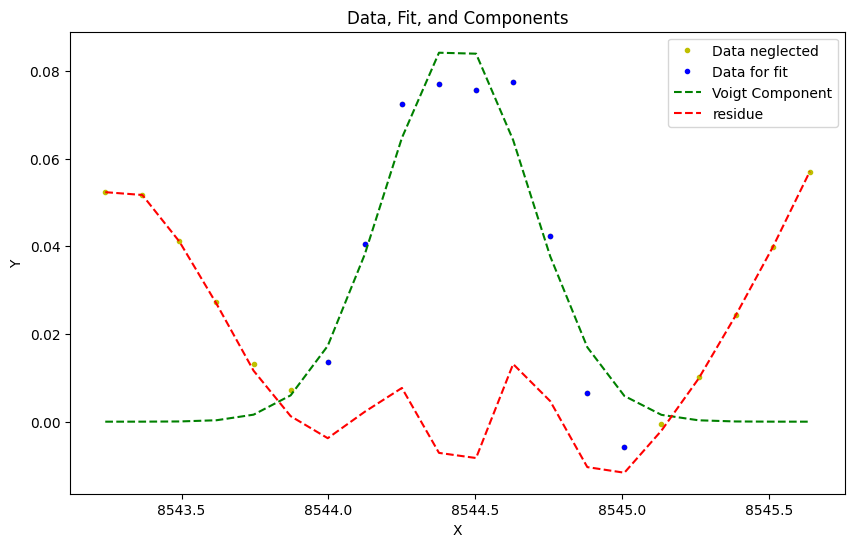

param_fit[-1] = (array([ 7.88487039e-02,  8.54443852e+03, -2.69757569e-01, -3.07802339e-04]), array([2.94464262e+00, 2.85449693e-02, 2.69970725e-02, 4.75800972e+03])). Here comes the plot:


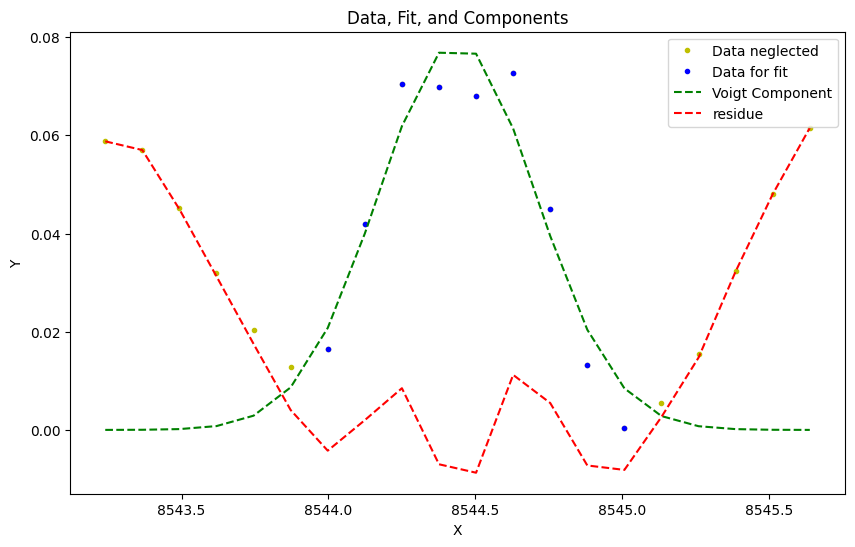

param_fit[-1] = (array([ 6.81187402e-02,  8.54441454e+03, -2.86718860e-01,  8.40464271e-05]), array([2.18089298e-01, 3.61985180e-02, 4.10476412e-02, 1.53683765e+03])). Here comes the plot:


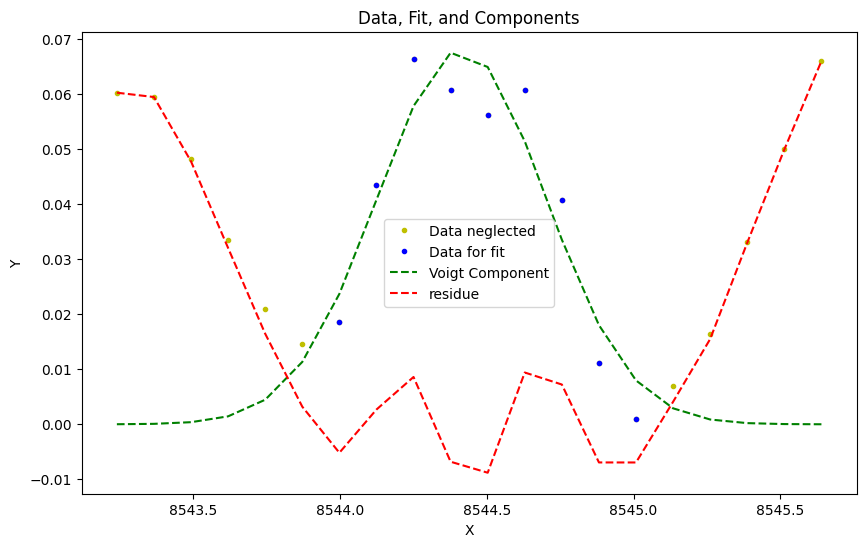

param_fit[-1] = (array([ 6.25882622e-02,  8.54442614e+03, -3.13389534e-01,  1.05734286e-03]), array([9.16988476e+00, 3.55420556e-02, 4.67092089e-02, 6.80953571e+03])). Here comes the plot:


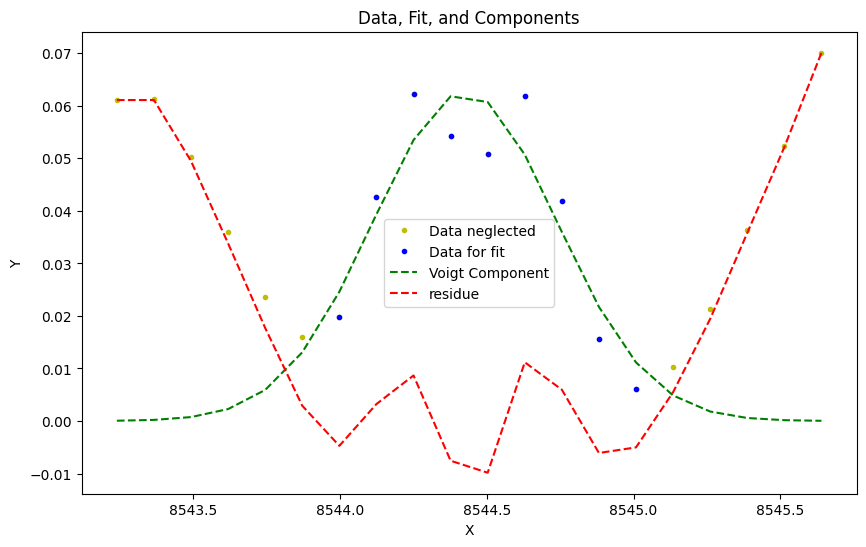

param_fit[-1] = (array([ 6.98206524e-02,  8.54438485e+03, -3.24763289e-01,  3.14674460e-01]), array([0.00921667, 0.0426889 , 0.48208086, 0.95441023])). Here comes the plot:


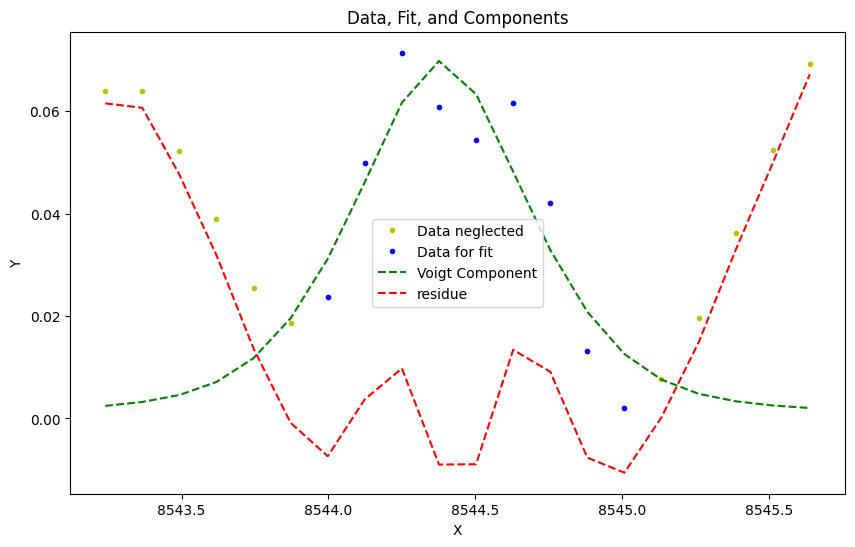

vlim = 0.07726704985145333


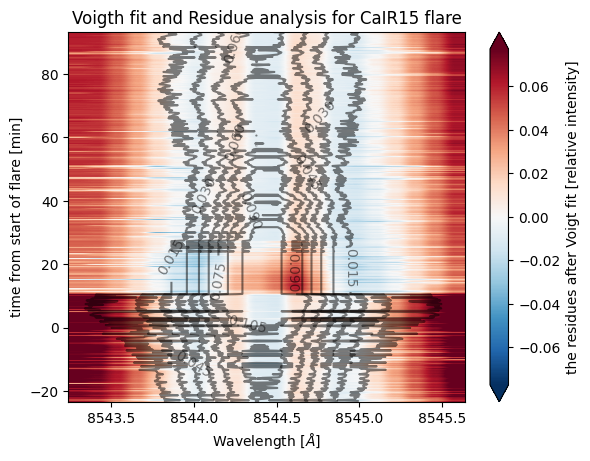

the correction factor is 0.8661149805010958
param_fit[-1] = (array([ 5.18600413e-02,  6.56453281e+03, -3.39672533e-01, -1.69982247e-04]), array([1.60967100e+00, 2.53470009e-02, 2.40873752e-02, 5.47193521e+03])). Here comes the plot:


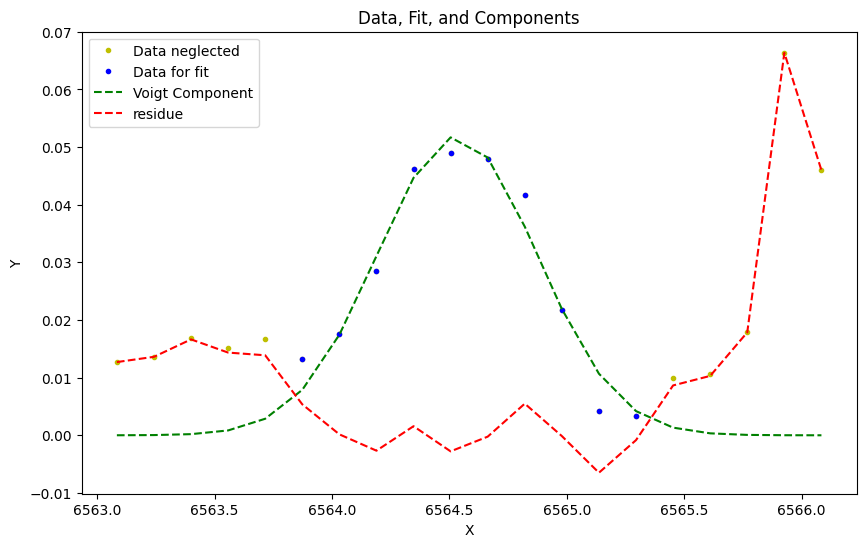

param_fit[-1] = (array([ 5.19228090e-02,  6.56453387e+03, -2.80965963e-03,  4.07295176e-01]), array([7.96353321e+01, 2.86434092e-02, 4.52774834e+04, 4.92739483e-02])). Here comes the plot:


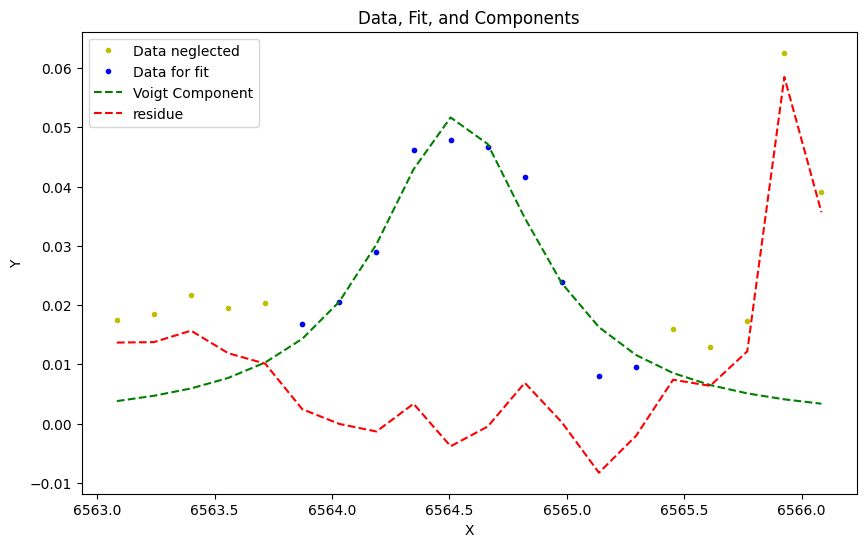

param_fit[-1] = (array([1.09910888e-01, 6.56460844e+03, 3.62864433e-01, 4.03274311e-05]), array([1.95859732e-01, 1.98321983e-02, 2.02184425e-02, 8.34085285e+02])). Here comes the plot:


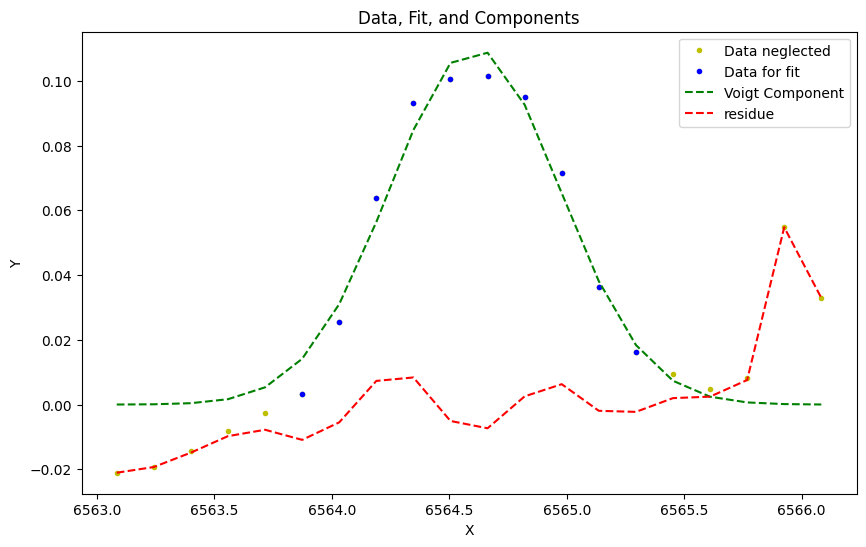

param_fit[-1] = (array([ 7.92709858e-02,  6.56459263e+03, -3.26196953e-01, -7.40117881e-05]), array([1.04418769e+00, 1.61074002e-02, 1.62388822e-02, 2.60423177e+03])). Here comes the plot:


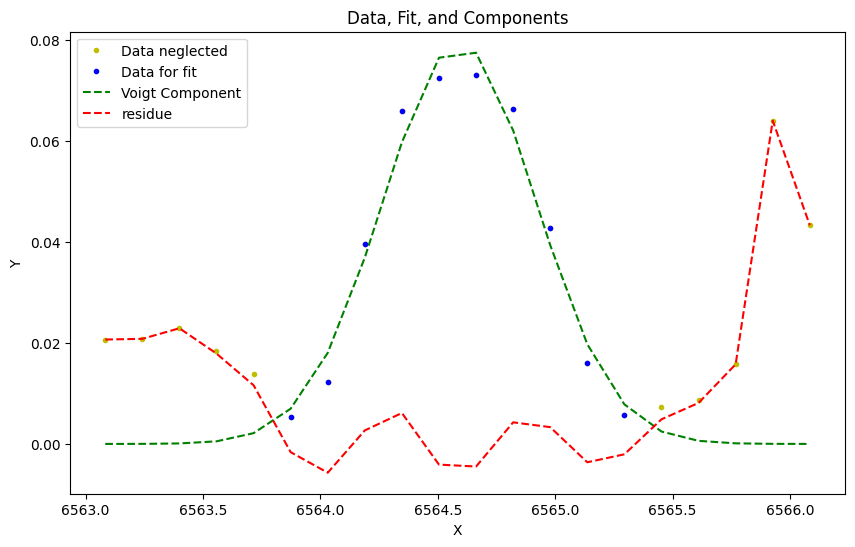

param_fit[-1] = (array([ 6.49979276e-02,  6.56458298e+03,  3.04311967e-01, -5.71038285e-04]), array([3.80146535e+00, 1.90548160e-02, 1.97214305e-02, 4.74121287e+03])). Here comes the plot:


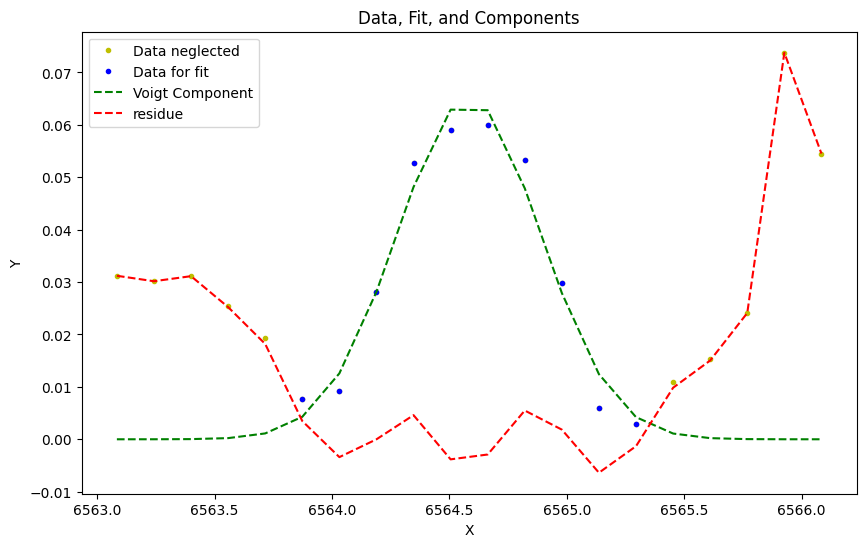

param_fit[-1] = (array([ 6.88983643e-02,  6.56456082e+03, -3.04713016e-01,  2.47190680e-04]), array([7.13324829e-01, 2.36292726e-02, 2.54862212e-02, 2.92602712e+03])). Here comes the plot:


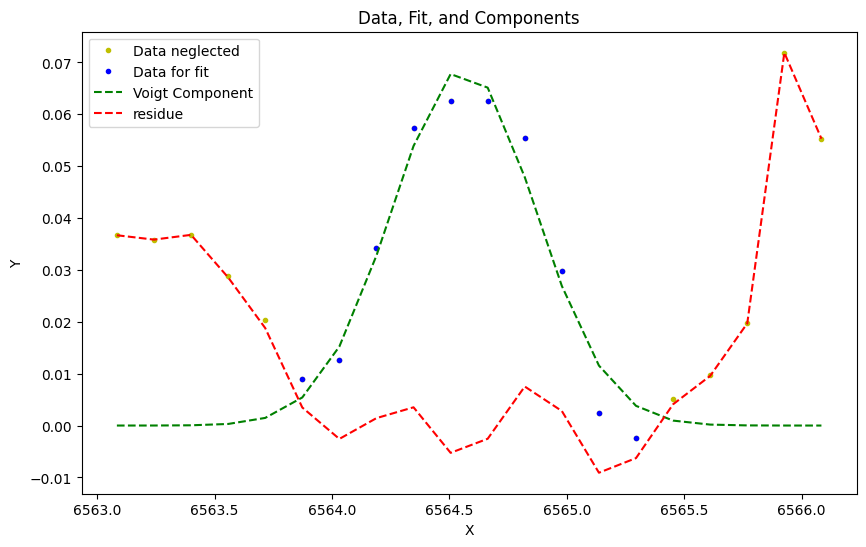

param_fit[-1] = (array([ 6.25576029e-02,  6.56455558e+03, -3.16234739e-01, -7.94432565e-05]), array([2.50549415e+00, 2.23447029e-02, 2.18935570e-02, 5.03832009e+03])). Here comes the plot:


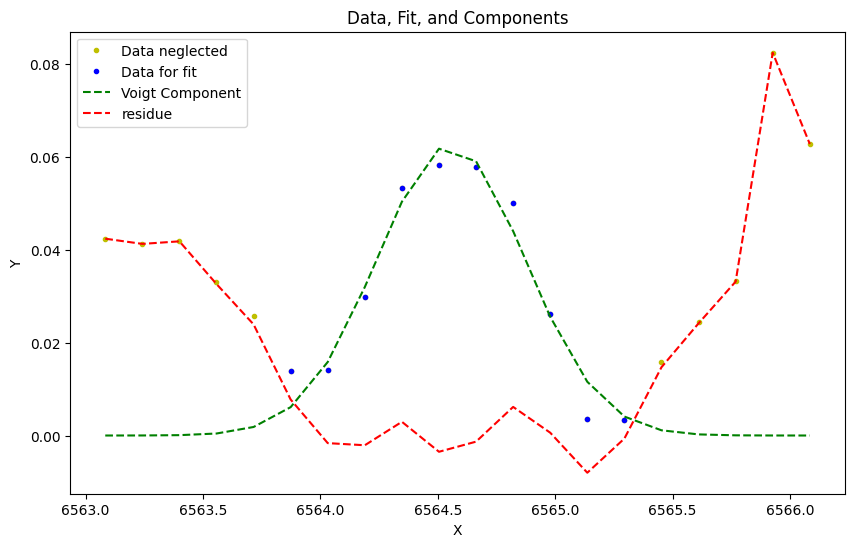

param_fit[-1] = (array([ 4.77864411e-02,  6.56453172e+03, -2.68368978e-01,  4.45862752e-01]), array([0.00512994, 0.03910791, 0.23693079, 0.07457008])). Here comes the plot:


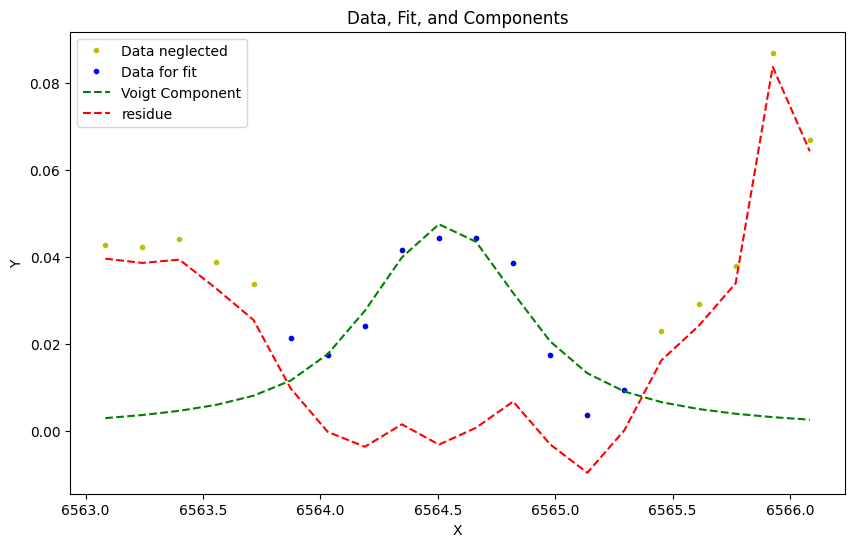

param_fit[-1] = (array([5.15913370e-02, 6.56456039e+03, 2.20145486e-01, 4.86898088e-01]), array([0.0050602 , 0.03544939, 0.2481174 , 0.08989991])). Here comes the plot:


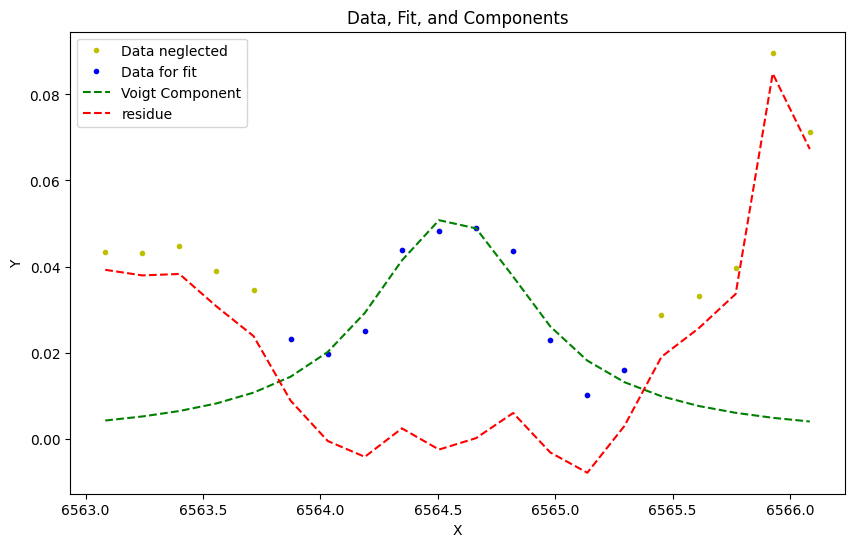

param_fit[-1] = (array([ 5.20095792e-02,  6.56452299e+03, -2.21533935e-01,  5.45604644e-01]), array([0.00529163, 0.0399818 , 0.33843787, 0.13295456])). Here comes the plot:


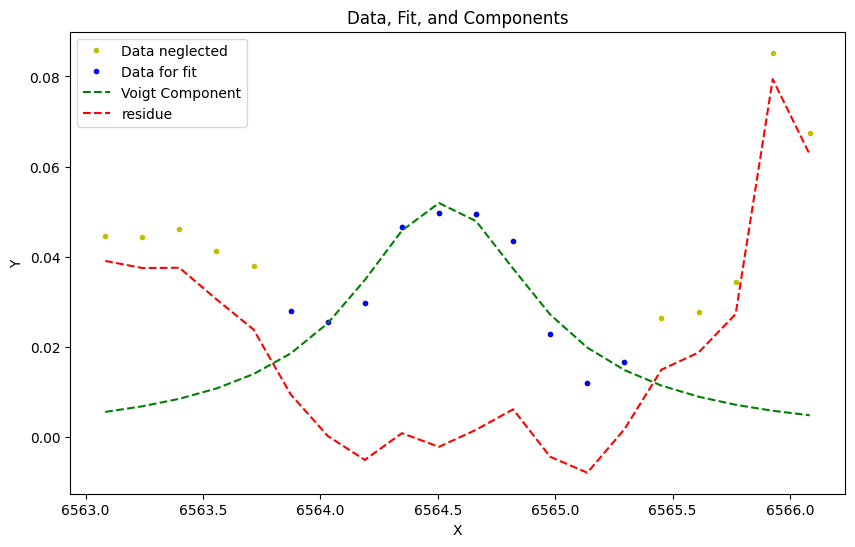

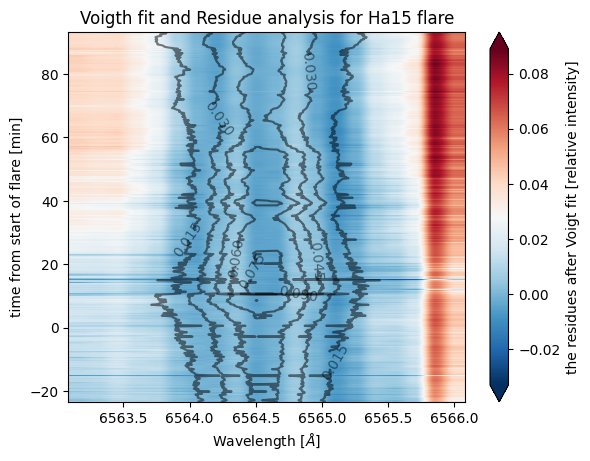

In [18]:
reload(un)
lines = ["CaIR15", "Ha15"]
offsets = [0.012*0.95, 0.023, 0.05]

data = un.load_for_further_analysis(lines, full_path = un.full_path("15"))

print(data.keys())

initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[0.12,  8544.4, -2.62017731e-01,  4.46885934e-04],
                   "Fe6173":[4.13090273e-02, 6.1728106e+03, -1.55441909e-03, 4.25981451e-02]}
lnp=[[0,1,2,3,4,5, -5,-4,-3,-2,-1], [0,1,2,3,4,-5,-4,-3,-2,-1], []]

make_full_analysis(data, lines, offsets=offsets, init_guesses=initial_guesses, plot_rate=150, list_neglect_points=lnp)

